In [ ]:
# 1. Імпорт бібліотек
!pip install optuna --quiet
!pip install shap --quiet

# --- Системні бібліотеки для роботи з файлами ---
from google.colab import files          # Завантаження файлів з Colab
import zipfile                           # Розпакування .zip
import os                                # Робота з файловою системою

# --- Основні бібліотеки для аналізу даних та графіків ---
import pandas as pd                      # Робота з таблицями
import numpy as np                       # Робота з масивами
import matplotlib.pyplot as plt          # Побудова графіків
import seaborn as sns                    # Стилізовані графіки поверх matplotlib

# --- Обробка попереджень ---
import warnings
warnings.filterwarnings("ignore", category=UserWarning)

# --- ML-модель: LightGBM ---
from lightgbm import LGBMClassifier

# --- Метрика оцінки для задачі класифікації з дисбалансом ---
from sklearn.metrics import matthews_corrcoef

# --- Оптимізація гіперпараметрів ---
import optuna

# --- SHAP: пояснення роботи моделей на деревах ---
import shap


In [ ]:
# Завантаження zip-файлу з локального комп’ютера
uploaded = files.upload()

Saving test-task-for-ds-churn-prediction-2025-06.zip to test-task-for-ds-churn-prediction-2025-06.zip


In [ ]:
# Розпаковка архіву
zip_filename = next(iter(uploaded))
with zipfile.ZipFile(zip_filename, 'r') as zip_ref:
    zip_ref.extractall('/content')

In [ ]:
# Перевірка, які файли з’явились у директорії після розпакування архіву
print("✅ Розпаковані файли:", os.listdir('/content'))

✅ Розпаковані файли: ['.config', 'sample.csv', 'test.csv', 'test-task-for-ds-churn-prediction-2025-06.zip', 'train.csv', 'sample_data']


In [ ]:
# Завантаження CSV-файлів у таблиці pandas
train = pd.read_csv('/content/train.csv')      # Навчальний набір даних
test = pd.read_csv('/content/test.csv')        # Тестовий набір (без target)
sample = pd.read_csv('/content/sample.csv')    # Шаблон для submission

# Перевіримо розмірність завантажених таблиць
print("train shape:", train.shape)
print("test shape:", test.shape)
print("sample shape:", sample.shape)

# Переглянемо перші 5 рядків навчального набору
train.head()

train shape: (24000, 49)
test shape: (6000, 48)
sample shape: (6000, 2)


Unnamed: 0  ses_rec  ses_rec_avg  ses_rec_sd  ses_rec_cv   user_rec  \
0       15678     13.0     2.500000    2.500000    1.000000  19.000000   
1        3271     26.0     2.000000    0.000000    0.000000  32.000000   
2       28682     22.0     0.000000    0.000000   -1.000000  22.000000   
3       28028      0.0     0.082336    0.082336   -0.670656   0.329344   
4       16961     24.0     0.000000    0.000000   -1.000000  24.000000   

      ses_n   ses_n_r  int_n   int_n_r  ...  int_cat16_n  int_cat17_n  \
0  3.000000  0.157895    4.0  1.333333  ...            0            0   
1  3.000000  0.093750    3.0  1.000000  ...            0            0   
2  2.000000  0.090909    3.0  1.500000  ...            0            0   
3  2.164672 -0.588320    5.0  2.362773  ...            0            5   
4  2.000000  0.083333    4.0  2.000000  ...            0            4   

   int_cat18_n  int_cat19_n  int_cat20_n  int_cat21_n  int_cat22_n  \
0            0            0            0            0            4   
1            0            0            0            1            1   
2            0            0            0            0            3   
3            0            0            0            0            0   
4            0            0            0            0            0   

   int_cat23_n  int_cat24_n  target_class  
0            0            0             1  
1            0            0             1  
2            0            0             1  
3            0            0             0  
4            0            0             1  

[5 rows x 49 columns]

In [ ]:
# Видаляємо колонку 'Unnamed: 0', яка могла з’явитися при збереженні CSV з індексом
train = train.drop(columns=['Unnamed: 0'], errors='ignore')
test = test.drop(columns=['Unnamed: 0'], errors='ignore')

# Перейменовуємо колонку 'target_class' → 'target' для зручності
train = train.rename(columns={'target_class': 'target'})

In [ ]:
# Перевіряємо наявність повністю ідентичних рядків у train
print(f"Повних дублікатів у train: {train.duplicated().sum()}")

# Якщо є колонка 'ID' — перевіряємо унікальність ідентифікаторів
if 'ID' in train.columns:
    print(f"Дублікатів ID у train: {train['ID'].duplicated().sum()}")

Повних дублікатів у train: 166


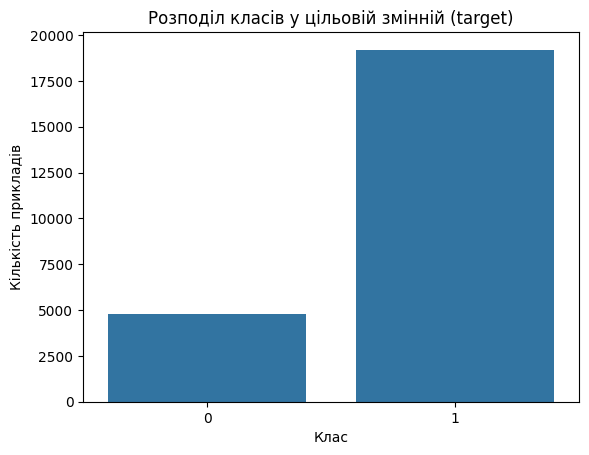

Target distribution (частка кожного класу):
 target
1    0.8
0    0.2
Name: proportion, dtype: float64


In [ ]:
# Візуалізуємо розподіл класів у цільовій змінній
sns.countplot(x='target', data=train)
plt.title("Розподіл класів у цільовій змінній (target)")
plt.xlabel("Клас")
plt.ylabel("Кількість прикладів")
plt.show()

# Друкуємо частку кожного класу у відсотках
print("Target distribution (частка кожного класу):\n", train['target'].value_counts(normalize=True))

In [ ]:
# Обчислюємо частку пропущених значень у кожній колонці
missing = train.isnull().mean().sort_values(ascending=False)

# Вибираємо лише ті колонки, де є пропущені значення
missing = missing[missing > 0]

# Візуалізація або повідомлення, якщо пропущених значень немає
if not missing.empty:
    plt.figure(figsize=(10, 6))
    missing.plot(kind='barh')
    plt.title("Частка пропущених значень по ознаках")
    plt.xlabel("Частка пропусків")
    plt.show()
else:
    print("Немає пропущених значень у train.csv")

Немає пропущених значень у train.csv


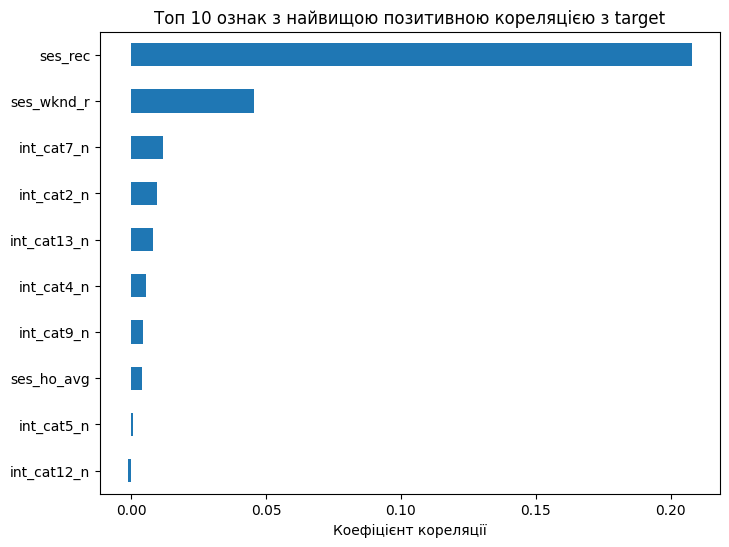

In [ ]:
# Обчислюємо кореляційну матрицю лише для числових ознак
corr = train.corr(numeric_only=True)

# Вибираємо топ-10 ознак із найсильнішою позитивною кореляцією з target
top_corr = corr['target'].drop('target').sort_values(ascending=False).head(10)

# Побудова горизонтального bar-графіка
plt.figure(figsize=(8, 6))
top_corr.plot(kind='barh')
plt.title("Топ 10 ознак з найвищою позитивною кореляцією з target")
plt.xlabel("Коефіцієнт кореляції")
plt.gca().invert_yaxis()
plt.show()

**Проміжний висновок: кореляційний аналіз**
На основі обчисленої кореляційної матриці було виділено топ-10 ознак, які мають найбільший позитивний лінійний зв’язок із цільовою змінною target.

**Найбільш інформативними ознаками за кореляцією є**:
* ses_rec — коефіцієнт > 0.20
* ses_wknd_r — близько 0.05
* серія ознак int_catX_n, які демонструють слабкий, але ненульовий зв’язок

Це свідчить, що:
* Давність останньої сесії (ses_rec) є потужним індикатором потенційного відтоку клієнта. Чим більше днів пройшло з моменту останньої активності, тим імовірніше, що клієнт більше не користується сервісом.
* Частка сесій у вихідні (ses_wknd_r) також має певний вплив: можливо, активні користувачі частіше заходять у робочі дні.
* Інші ознаки мають помітно нижчі значення кореляції, що не виключає їх корисності — проте робить їхню лінійну залежність з target менш значущою.

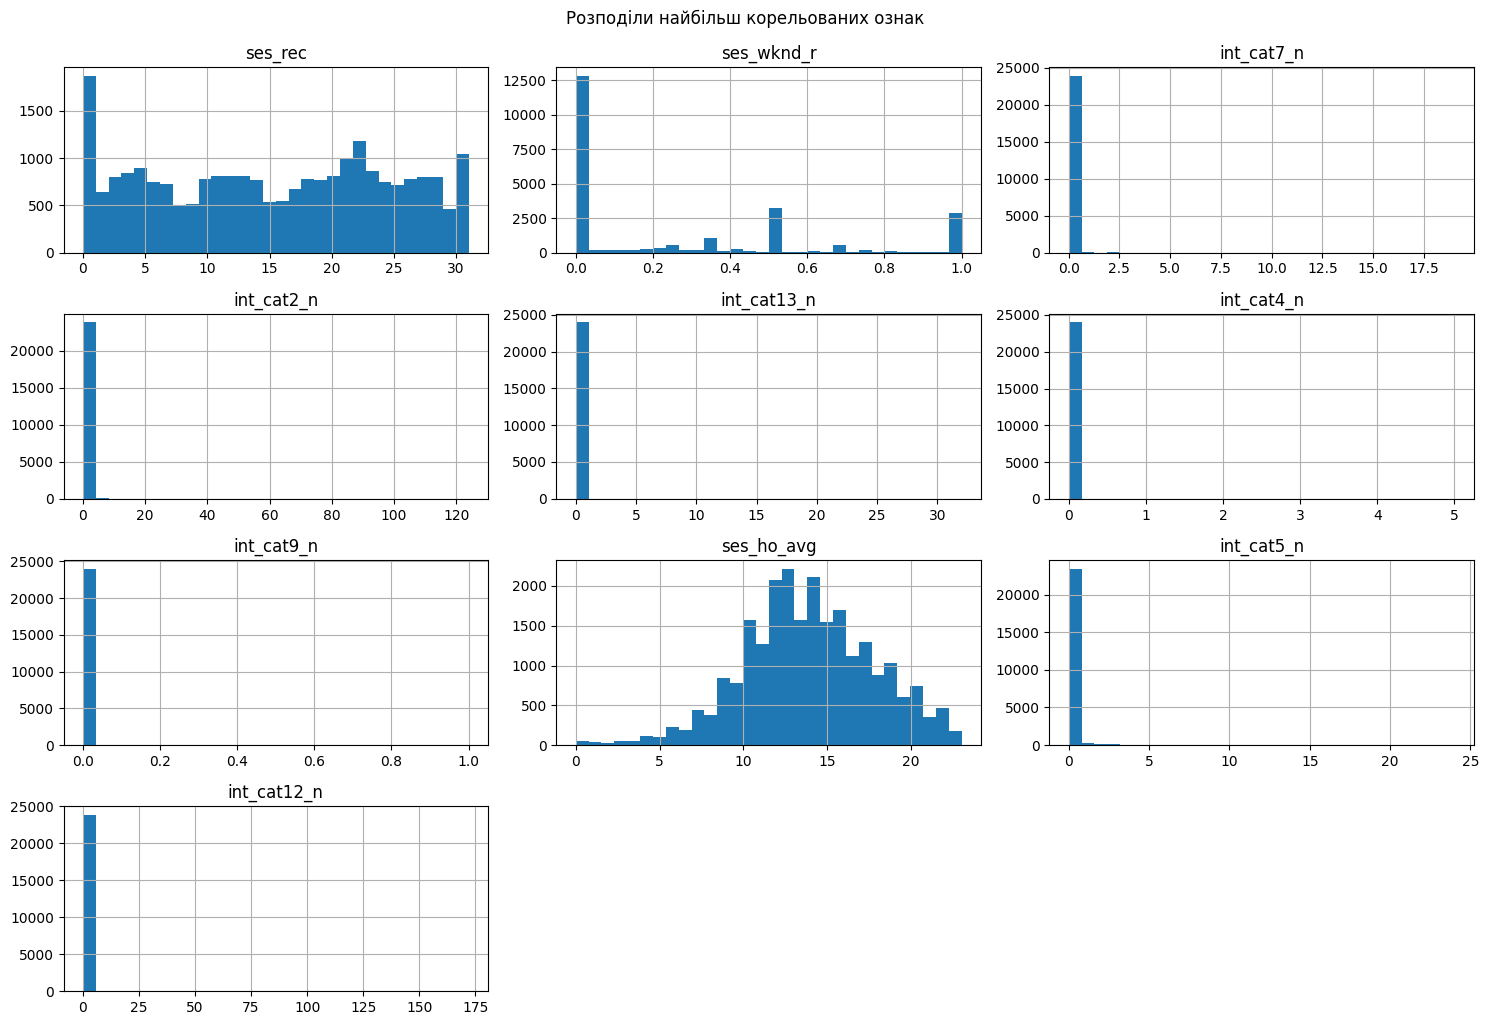

In [ ]:
# Отримуємо список назв найбільш корельованих ознак із target
top_features = top_corr.index.tolist()

# Побудова гістограм для кожної з них
train[top_features].hist(figsize=(15, 10), bins=30)

# Заголовок для усіх підграфіків
plt.tight_layout()
plt.suptitle("Розподіли найбільш корельованих ознак", y=1.02)
plt.show()

**Графіки показують**, що
* ses_rec — має досить рівномірний розподіл, але з піками біля 0 і 30 (типово для "давності останньої активності").
* ses_wknd_r — майже бінарна: багато користувачів або ніколи, або завжди активні у вихідні.
* ses_ho_avg — нормально розподілена, чудова для моделей.

Але більшість int_catX_n мають сильно скошений (спарсований) розподіл:
* майже всі значення = 0
* деякі поодинокі значення мають величини десятків або сотень

**Проміжний висновок:**
* ses_rec, ses_wknd_r, ses_ho_avg — фічі з інформативним розподілом, які варто залишити без змін.
* int_catX_n фічі мають високий спарсинг:
** можуть мати потенційну цінність у нелінійних моделях (як LightGBM),
** але не підходять для моделей, чутливих до нормальності або відстаней (наприклад, логістичної регресії без трансформацій).

Отже, не варто відкидати int_catX_n, але варто дати моделі (LightGBM) можливість вирішити, наскільки вони важливі.

In [ ]:
# Імпортуємо необхідні інструменти для підготовки даних:
# train_test_split — для розділення датасету на навчальну та валідаційну вибірки
# StandardScaler — для нормалізації числових ознак (масштабування до нульового середнього та одиничного стандартного відхилення)
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

In [ ]:
# Видаляємо повністю однакові рядки з датасету train
# Це допомагає уникнути повторень, які можуть викривити навчання моделі
train = train.drop_duplicates()

In [ ]:
# 🧪 Відокремлюємо ознаки (X) та цільову змінну (y)
# X — усі колонки, окрім 'target'
# y — саме цільова змінна, яку будемо передбачати (0 або 1)
X = train.drop(columns=['target'])
y = train['target']

In [ ]:
# Масштабуємо ознаки: перетворюємо всі числові колонки до одного масштабу
# StandardScaler стандартизує ознаки так, щоб вони мали середнє 0 і стандартне відхилення 1
# Це важливо для моделей, чутливих до масштабу (логістична регресія, KNN, тощо),
# а також допомагає LightGBM швидше сходитися

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

In [ ]:
# Видаляємо колонку 'ID', якщо вона присутня у тестовому наборі (вона не є ознакою)
# Масштабуємо тестові ознаки за тими ж параметрами, що й тренувальні (fit вже виконано на train)
# Це гарантує, що модель бачить тестові дані у тому ж масштабі, що й під час навчання

X_test = test.drop(columns=['ID'], errors='ignore')
X_test_scaled = scaler.transform(X_test)

In [ ]:
# Розділяємо дані на навчальну (X_train, y_train) та валідаційну (X_val, y_val) вибірки
# stratify=y — зберігає розподіл класів у обох частинах (важливо при дисбалансі)
# test_size=0.2 — 20% даних ідуть на валідацію
# random_state=42 — фіксуємо розподіл для повторюваності результатів

X_train, X_val, y_train, y_val = train_test_split(
    X_scaled, y,
    test_size=0.2,
    stratify=y,
    random_state=42
)

In [ ]:
# Виводимо розміри кожної частини даних:
# - навчальний набір (X_train)
# - валідаційний набір (X_val)
# - тестовий набір (X_test_scaled)

print(f"Train:      {X_train.shape}")
print(f"Validation: {X_val.shape}")
print(f"Test:       {X_test_scaled.shape}")

Train:      (19067, 47)
Validation: (4767, 47)
Test:       (6000, 47)


In [ ]:
# Імпортуємо LightGBM — потужний алгоритм градієнтного бустингу на деревах
import lightgbm as lgb

# Імпортуємо MCC — Matthews Correlation Coefficient
# Метрика, яка враховує всі елементи матриці помилок і підходить для дисбалансованих задач
from sklearn.metrics import matthews_corrcoef

LightGBM забезпечує високу точність та швидкість, а MCC є ідеальною метрикою для задач з дисбалансом класів.

In [ ]:
# Створюємо модель LightGBM для задачі класифікації
model = lgb.LGBMClassifier(
    n_estimators=1000,        # Кількість дерев (бустинг-ітерацій)
    learning_rate=0.05,       # Швидкість навчання — чим менша, тим точніше, але довше
    random_state=42,          # Фіксуємо результат для відтворюваності
    is_unbalance=True,        # Важливо: автоматично враховує дисбаланс класів
    n_jobs=-1                 # Використовує всі доступні ядра CPU
)

In [ ]:
# Навчаємо модель на тренувальних даних
# - Використовуємо валідаційний набір для контролю переобучення
# - Early stopping припиняє навчання, якщо метрика не покращується протягом 50 ітерацій

model.fit(
    X_train, y_train,
    eval_set=[(X_val, y_val)],                  # Валідаційний набір для відстеження якості
    eval_metric='binary_logloss',               # Метрика оцінки на валідації
    callbacks=[lgb.early_stopping(stopping_rounds=50)]  # Раннє зупинення
)

/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Info] Number of positive: 15227, number of negative: 3840
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.175335 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 6059
[LightGBM] [Info] Number of data points in the train set: 19067, number of used features: 42
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.798605 -> initscore=1.377598
[LightGBM] [Info] Start training from score 1.377598
Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[999]	valid_0's binary_logloss: 0.144378


LGBMClassifier(is_unbalance=True, learning_rate=0.05, n_estimators=1000,
               n_jobs=-1, random_state=42)

In [ ]:
# Отримуємо передбачення моделі для валідаційного набору
# Метод .predict() повертає класи (0 або 1) на основі порогового значення 0.5
y_val_pred = model.predict(X_val)

/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


In [ ]:
# Обчислюємо метрику MCC — підходить для задач із дисбалансованими класами
# Враховує всі 4 компоненти матриці помилок: TP, TN, FP, FN

mcc = matthews_corrcoef(y_val, y_val_pred)
print(f"Validation MCC (baseline): {mcc:.4f}")

Validation MCC (baseline): 0.8677


Чим ближче MCC до 1.0 — тим краще працює модель. Значення ≈ 0 — випадкові передбачення.

In [ ]:
# Функція, яку Optuna буде викликати на кожному кроці для тестування нової комбінації параметрів
# Мета: максимізувати MCC — метрику якості класифікації для дисбалансованих класів

def objective(trial):
    # Генерація набору гіперпараметрів, які буде тестувати Optuna
    params = {
        "n_estimators": 1000,  # кількість дерев
        "learning_rate": trial.suggest_float("learning_rate", 0.01, 0.3),
        "max_depth": trial.suggest_int("max_depth", 3, 12),
        "num_leaves": trial.suggest_int("num_leaves", 15, 150),
        "min_child_samples": trial.suggest_int("min_child_samples", 10, 100),
        "subsample": trial.suggest_float("subsample", 0.5, 1.0),
        "colsample_bytree": trial.suggest_float("colsample_bytree", 0.5, 1.0),
        "reg_alpha": trial.suggest_float("reg_alpha", 0.0, 1.0),
        "reg_lambda": trial.suggest_float("reg_lambda", 0.0, 1.0),
        "random_state": 42,
        "n_jobs": -1,
        "is_unbalance": True
    }

    # Ініціалізуємо модель з обраними параметрами
    model = LGBMClassifier(**params)

    # Навчання моделі з валідацією та ранньою зупинкою
    model.fit(
        X_train, y_train,
        eval_set=[(X_val, y_val)],
        eval_metric="binary_logloss",
        callbacks=[lgb.early_stopping(50)]
    )

    # Побудова прогнозу на валідаційному наборі
    preds = model.predict(X_val)

    # Обчислюємо MCC як метрику якості
    score = matthews_corrcoef(y_val, preds)
    return score  # Optuna буде її максимізувати

In [ ]:
# Створюємо об'єкт "дослідження" — Optuna Study
# direction="maximize" означає, що ми хочемо максимізувати метрику MCC

study = optuna.create_study(direction="maximize")

# Запускаємо оптимізацію: Optuna буде викликати функцію objective() 100 разів
# Кожна ітерація — нова комбінація гіперпараметрів
study.optimize(objective, n_trials=100)

[I 2025-06-09 09:38:24,063] A new study created in memory with name: no-name-1bd6a8bd-e6c8-4ad1-9ac4-6a6e05960870
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Info] Number of positive: 15227, number of negative: 3840
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.010266 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 6059
[LightGBM] [Info] Number of data points in the train set: 19067, number of used features: 42
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.798605 -> initscore=1.377598
[LightGBM] [Info] Start training from score 1.377598
Training until validation scores don't improve for 50 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM

/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
[I 2025-06-09 09:38:30,112] Trial 0 finished with value: 0.8793617186973298 and parameters: {'learning_rate': 0.1829016054244476, 'max_depth': 11, 'num_leaves': 49, 'min_child_samples': 35, 'subsample': 0.5304635261212973, 'colsample_bytree': 0.5216490674093002, 'reg_alpha': 0.5714256520326695, 'reg_lambda': 0.23408933712429292}. Best is trial 0 with value: 0.8793617186973298.


Early stopping, best iteration is:
[310]	valid_0's binary_logloss: 0.134857


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Info] Number of positive: 15227, number of negative: 3840
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.004130 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 6047
[LightGBM] [Info] Number of data points in the train set: 19067, number of used features: 40
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.798605 -> initscore=1.377598
[LightGBM] [Info] Start training from score 1.377598
Training until validation scores don't improve for 50 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM

/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
[I 2025-06-09 09:38:32,050] Trial 1 finished with value: 0.8699790706853358 and parameters: {'learning_rate': 0.2636479318021653, 'max_depth': 12, 'num_leaves': 93, 'min_child_samples': 93, 'subsample': 0.945500295631437, 'colsample_bytree': 0.9135667435615715, 'reg_alpha': 0.34650932129060474, 'reg_lambda': 0.008010267710756969}. Best is trial 0 with value: 0.8793617186973298.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Early stopping, best iteration is:
[141]	valid_0's binary_logloss: 0.146706


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Info] Number of positive: 15227, number of negative: 3840
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.004072 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 6047
[LightGBM] [Info] Number of data points in the train set: 19067, number of used features: 40
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.798605 -> initscore=1.377598
[LightGBM] [Info] Start training from score 1.377598
Training until validation scores don't improve for 50 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM

/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
[I 2025-06-09 09:38:35,894] Trial 2 finished with value: 0.8759391174752471 and parameters: {'learning_rate': 0.19657448750478218, 'max_depth': 11, 'num_leaves': 119, 'min_child_samples': 96, 'subsample': 0.9456751903653375, 'colsample_bytree': 0.8238649517620436, 'reg_alpha': 0.008727663894008808, 'reg_lambda': 0.10936993375255688}. Best is trial 0 with value: 0.8793617186973298.
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Info] Number of positive: 15227, number of negative: 3840
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.012448 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 6059
[LightGBM] [Info] Number of data points in the train set: 19067, number of used features: 42
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.798605 -> initscore=1.377598
[LightGBM] [Info] Start training from score 1.377598
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Training until validation scores don't improve for 50 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -in

/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
[I 2025-06-09 09:38:40,603] Trial 3 finished with value: 0.8096518379908799 and parameters: {'learning_rate': 0.013741991433659994, 'max_depth': 5, 'num_leaves': 68, 'min_child_samples': 19, 'subsample': 0.5280795224475783, 'colsample_bytree': 0.6086798859944424, 'reg_alpha': 0.6421448219998522, 'reg_lambda': 0.5130109585341887}. Best is trial 0 with value: 0.8793617186973298.
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Info] Number of positive: 15227, number of negative: 3840
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.007667 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 6059
[LightGBM] [Info] Number of data points in the train set: 19067, number of used features: 42
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.798605 -> initscore=1.377598
[LightGBM] [Info] Start training from score 1.377598
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Training until validation scores don't improve for 50 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -in

/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
[I 2025-06-09 09:38:45,810] Trial 4 finished with value: 0.8798633169790713 and parameters: {'learning_rate': 0.04107339417179706, 'max_depth': 6, 'num_leaves': 145, 'min_child_samples': 25, 'subsample': 0.9151993014813575, 'colsample_bytree': 0.6774931929885498, 'reg_alpha': 0.5895169173424163, 'reg_lambda': 0.5742733568242768}. Best is trial 4 with value: 0.8798633169790713.
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Info] Number of positive: 15227, number of negative: 3840
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.008136 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 6059
[LightGBM] [Info] Number of data points in the train set: 19067, number of used features: 42
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.798605 -> initscore=1.377598
[LightGBM] [Info] Start training from score 1.377598
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Training until validation scores don't improve for 50 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -in

/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
[I 2025-06-09 09:38:50,305] Trial 5 finished with value: 0.8698015772228763 and parameters: {'learning_rate': 0.19524407626523102, 'max_depth': 8, 'num_leaves': 107, 'min_child_samples': 46, 'subsample': 0.594219265879862, 'colsample_bytree': 0.6963066889046177, 'reg_alpha': 0.3024853598870849, 'reg_lambda': 0.5679404482627601}. Best is trial 4 with value: 0.8798633169790713.
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Info] Number of positive: 15227, number of negative: 3840
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.009159 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 6059
[LightGBM] [Info] Number of data points in the train set: 19067, number of used features: 42
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.798605 -> initscore=1.377598
[LightGBM] [Info] Start training from score 1.377598
Training until validation scores don't improve for 50 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -in

/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
[I 2025-06-09 09:38:52,189] Trial 6 finished with value: 0.8717913941187122 and parameters: {'learning_rate': 0.23868737597932008, 'max_depth': 12, 'num_leaves': 71, 'min_child_samples': 29, 'subsample': 0.5080156524011575, 'colsample_bytree': 0.6255312024637991, 'reg_alpha': 0.5844172110911805, 'reg_lambda': 0.42508112336143977}. Best is trial 4 with value: 0.8798633169790713.


Early stopping, best iteration is:
[156]	valid_0's binary_logloss: 0.1405


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Info] Number of positive: 15227, number of negative: 3840
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.004258 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 6059
[LightGBM] [Info] Number of data points in the train set: 19067, number of used features: 42
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.798605 -> initscore=1.377598
[LightGBM] [Info] Start training from score 1.377598
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Training until validation scores don't improve for 50 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM

/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
[I 2025-06-09 09:38:54,873] Trial 7 finished with value: 0.8244230746337949 and parameters: {'learning_rate': 0.061211741824598556, 'max_depth': 3, 'num_leaves': 64, 'min_child_samples': 60, 'subsample': 0.9295906804721704, 'colsample_bytree': 0.8674374255836002, 'reg_alpha': 0.9407521046069459, 'reg_lambda': 0.8468678406806031}. Best is trial 4 with value: 0.8798633169790713.
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Info] Number of positive: 15227, number of negative: 3840
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.004077 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 6047
[LightGBM] [Info] Number of data points in the train set: 19067, number of used features: 40
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.798605 -> initscore=1.377598
[LightGBM] [Info] Start training from score 1.377598
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Training until validation scores don't improve for 50 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM

/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
[I 2025-06-09 09:38:56,675] Trial 8 finished with value: 0.8677803544987696 and parameters: {'learning_rate': 0.2949216454083798, 'max_depth': 7, 'num_leaves': 144, 'min_child_samples': 86, 'subsample': 0.9039219430432981, 'colsample_bytree': 0.8968387555685309, 'reg_alpha': 0.010189806536594848, 'reg_lambda': 0.9655602512943143}. Best is trial 4 with value: 0.8798633169790713.
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Info] Number of positive: 15227, number of negative: 3840
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003843 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 6059
[LightGBM] [Info] Number of data points in the train set: 19067, number of used features: 42
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.798605 -> initscore=1.377598
[LightGBM] [Info] Start training from score 1.377598
Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[1000]	valid_0's binary_logloss: 0.142566


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
[I 2025-06-09 09:39:02,891] Trial 9 finished with value: 0.8776042249746411 and parameters: {'learning_rate': 0.08998647450042196, 'max_depth': 11, 'num_leaves': 18, 'min_child_samples': 38, 'subsample': 0.8382600322589456, 'colsample_bytree': 0.5907287422160057, 'reg_alpha': 0.3654975256998513, 'reg_lambda': 0.07251043772090893}. Best is trial 4 with value: 0.8798633169790713.
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Info] Number of positive: 15227, number of negative: 3840
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.007930 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 6063
[LightGBM] [Info] Number of data points in the train set: 19067, number of used features: 43
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.798605 -> initscore=1.377598
[LightGBM] [Info] Start training from score 1.377598
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Training until validation scores don't improve for 50 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -in

/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
[I 2025-06-09 09:39:07,980] Trial 10 finished with value: 0.8738660904957746 and parameters: {'learning_rate': 0.08860921950515865, 'max_depth': 8, 'num_leaves': 149, 'min_child_samples': 13, 'subsample': 0.7292520864936739, 'colsample_bytree': 0.7507807723687925, 'reg_alpha': 0.8544838301412474, 'reg_lambda': 0.7026194627449474}. Best is trial 4 with value: 0.8798633169790713.
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Info] Number of positive: 15227, number of negative: 3840
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.004009 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 6059
[LightGBM] [Info] Number of data points in the train set: 19067, number of used features: 42
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.798605 -> initscore=1.377598
[LightGBM] [Info] Start training from score 1.377598
Training until validation scores don't improve for 50 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM

/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
[I 2025-06-09 09:39:12,180] Trial 11 finished with value: 0.8896258525819062 and parameters: {'learning_rate': 0.14368277890863698, 'max_depth': 6, 'num_leaves': 37, 'min_child_samples': 60, 'subsample': 0.7130720636987363, 'colsample_bytree': 0.5236533541723795, 'reg_alpha': 0.7457697212878587, 'reg_lambda': 0.32048868330358915}. Best is trial 11 with value: 0.8896258525819062.
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Info] Number of positive: 15227, number of negative: 3840
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.010859 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 6059
[LightGBM] [Info] Number of data points in the train set: 19067, number of used features: 42
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.798605 -> initscore=1.377598
[LightGBM] [Info] Start training from score 1.377598
Training until validation scores don't improve for 50 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM

/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
[I 2025-06-09 09:39:18,395] Trial 12 finished with value: 0.8881549779203479 and parameters: {'learning_rate': 0.12924827403457603, 'max_depth': 6, 'num_leaves': 24, 'min_child_samples': 59, 'subsample': 0.7296569747217728, 'colsample_bytree': 0.5214022271660645, 'reg_alpha': 0.7829469473954125, 'reg_lambda': 0.32365287773221824}. Best is trial 11 with value: 0.8896258525819062.
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Info] Number of positive: 15227, number of negative: 3840
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.007316 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 6053
[LightGBM] [Info] Number of data points in the train set: 19067, number of used features: 41
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.798605 -> initscore=1.377598
[LightGBM] [Info] Start training from score 1.377598
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Training until validation scores don't improve for 50 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -in

/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
[I 2025-06-09 09:39:21,660] Trial 13 finished with value: 0.8771912042718357 and parameters: {'learning_rate': 0.12875683569604313, 'max_depth': 4, 'num_leaves': 26, 'min_child_samples': 65, 'subsample': 0.6978209066626346, 'colsample_bytree': 0.506661918596753, 'reg_alpha': 0.7673644537490841, 'reg_lambda': 0.318275839498098}. Best is trial 11 with value: 0.8896258525819062.
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Info] Number of positive: 15227, number of negative: 3840
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003936 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 6053
[LightGBM] [Info] Number of data points in the train set: 19067, number of used features: 41
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.798605 -> initscore=1.377598
[LightGBM] [Info] Start training from score 1.377598
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Training until validation scores don't improve for 50 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM

/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
[I 2025-06-09 09:39:25,460] Trial 14 finished with value: 0.8802128656728573 and parameters: {'learning_rate': 0.1373507435550446, 'max_depth': 6, 'num_leaves': 45, 'min_child_samples': 74, 'subsample': 0.6566144865703714, 'colsample_bytree': 0.5479983636882404, 'reg_alpha': 0.7514445944375014, 'reg_lambda': 0.284857111001651}. Best is trial 11 with value: 0.8896258525819062.
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Info] Number of positive: 15227, number of negative: 3840
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.295033 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 6059
[LightGBM] [Info] Number of data points in the train set: 19067, number of used features: 42
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.798605 -> initscore=1.377598
[LightGBM] [Info] Start training from score 1.377598
Training until validation scores don't improve for 50 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM

/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
[I 2025-06-09 09:39:31,776] Trial 15 finished with value: 0.8824024193060611 and parameters: {'learning_rate': 0.11561864059114968, 'max_depth': 7, 'num_leaves': 36, 'min_child_samples': 48, 'subsample': 0.8017323607939834, 'colsample_bytree': 0.7684799060992725, 'reg_alpha': 0.9959304654224425, 'reg_lambda': 0.38993669921661467}. Best is trial 11 with value: 0.8896258525819062.
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Info] Number of positive: 15227, number of negative: 3840
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.004345 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 6053
[LightGBM] [Info] Number of data points in the train set: 19067, number of used features: 41
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.798605 -> initscore=1.377598
[LightGBM] [Info] Start training from score 1.377598
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[874]	valid_0's binary_logloss: 0.140222


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
[I 2025-06-09 09:39:35,407] Trial 16 finished with value: 0.8789466041096591 and parameters: {'learning_rate': 0.16052203003904092, 'max_depth': 9, 'num_leaves': 15, 'min_child_samples': 74, 'subsample': 0.7917140734451712, 'colsample_bytree': 0.9676294537128105, 'reg_alpha': 0.7390658351666628, 'reg_lambda': 0.18309703021409168}. Best is trial 11 with value: 0.8896258525819062.
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Info] Number of positive: 15227, number of negative: 3840
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.007671 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 6053
[LightGBM] [Info] Number of data points in the train set: 19067, number of used features: 41
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.798605 -> initscore=1.377598
[LightGBM] [Info] Start training from score 1.377598
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Training until validation scores don't improve for 50 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -in

/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
[I 2025-06-09 09:39:38,464] Trial 17 finished with value: 0.8818439592943111 and parameters: {'learning_rate': 0.22168852702056582, 'max_depth': 5, 'num_leaves': 51, 'min_child_samples': 70, 'subsample': 0.6486558289306539, 'colsample_bytree': 0.6788395024872493, 'reg_alpha': 0.8690210084661876, 'reg_lambda': 0.687371675835384}. Best is trial 11 with value: 0.8896258525819062.
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Info] Number of positive: 15227, number of negative: 3840
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.299376 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 6059
[LightGBM] [Info] Number of data points in the train set: 19067, number of used features: 42
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.798605 -> initscore=1.377598
[LightGBM] [Info] Start training from score 1.377598
Training until validation scores don't improve for 50 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM

/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
[I 2025-06-09 09:39:43,043] Trial 18 finished with value: 0.8836267487788415 and parameters: {'learning_rate': 0.15558876744866063, 'max_depth': 9, 'num_leaves': 33, 'min_child_samples': 52, 'subsample': 0.763387657442621, 'colsample_bytree': 0.5590734010444672, 'reg_alpha': 0.4208680435984714, 'reg_lambda': 0.3972627029499638}. Best is trial 11 with value: 0.8896258525819062.
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Info] Number of positive: 15227, number of negative: 3840
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.007929 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 6059
[LightGBM] [Info] Number of data points in the train set: 19067, number of used features: 42
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.798605 -> initscore=1.377598
[LightGBM] [Info] Start training from score 1.377598
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Training until validation scores don't improve for 50 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -in

/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
[I 2025-06-09 09:39:45,795] Trial 19 finished with value: 0.8528750739045128 and parameters: {'learning_rate': 0.10044224069778569, 'max_depth': 3, 'num_leaves': 85, 'min_child_samples': 60, 'subsample': 0.8358400786134008, 'colsample_bytree': 0.6424204982890038, 'reg_alpha': 0.1893198515535326, 'reg_lambda': 0.14637596812624643}. Best is trial 11 with value: 0.8896258525819062.
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Info] Number of positive: 15227, number of negative: 3840
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003841 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 6053
[LightGBM] [Info] Number of data points in the train set: 19067, number of used features: 41
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.798605 -> initscore=1.377598
[LightGBM] [Info] Start training from score 1.377598
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Training until validation scores don't improve for 50 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM

/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
[I 2025-06-09 09:39:50,315] Trial 20 finished with value: 0.8661925595577271 and parameters: {'learning_rate': 0.06894288768307272, 'max_depth': 5, 'num_leaves': 60, 'min_child_samples': 84, 'subsample': 0.6021705599528233, 'colsample_bytree': 0.500420385794835, 'reg_alpha': 0.6858087324641706, 'reg_lambda': 0.287675137999346}. Best is trial 11 with value: 0.8896258525819062.
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Info] Number of positive: 15227, number of negative: 3840
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.004118 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 6059
[LightGBM] [Info] Number of data points in the train set: 19067, number of used features: 42
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.798605 -> initscore=1.377598
[LightGBM] [Info] Start training from score 1.377598
Training until validation scores don't improve for 50 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM

/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
[I 2025-06-09 09:39:55,281] Trial 21 finished with value: 0.8773499618908454 and parameters: {'learning_rate': 0.15812431635602894, 'max_depth': 9, 'num_leaves': 37, 'min_child_samples': 51, 'subsample': 0.7509667761366776, 'colsample_bytree': 0.5683739682846849, 'reg_alpha': 0.4438307961466671, 'reg_lambda': 0.3811272748705993}. Best is trial 11 with value: 0.8896258525819062.
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Info] Number of positive: 15227, number of negative: 3840
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.004069 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 6059
[LightGBM] [Info] Number of data points in the train set: 19067, number of used features: 42
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.798605 -> initscore=1.377598
[LightGBM] [Info] Start training from score 1.377598
Training until validation scores don't improve for 50 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM

/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
[I 2025-06-09 09:39:58,471] Trial 22 finished with value: 0.8790314825300265 and parameters: {'learning_rate': 0.145806906570543, 'max_depth': 9, 'num_leaves': 28, 'min_child_samples': 41, 'subsample': 0.7077440283285382, 'colsample_bytree': 0.5590706695242568, 'reg_alpha': 0.46841543029298505, 'reg_lambda': 0.43439819899755383}. Best is trial 11 with value: 0.8896258525819062.
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Info] Number of positive: 15227, number of negative: 3840
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.004264 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 6059
[LightGBM] [Info] Number of data points in the train set: 19067, number of used features: 42
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.798605 -> initscore=1.377598
[LightGBM] [Info] Start training from score 1.377598
Training until validation scores don't improve for 50 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM

/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
[I 2025-06-09 09:40:02,045] Trial 23 finished with value: 0.8816706827497175 and parameters: {'learning_rate': 0.17017606849643127, 'max_depth': 6, 'num_leaves': 36, 'min_child_samples': 57, 'subsample': 0.7496496391724485, 'colsample_bytree': 0.5471883137818664, 'reg_alpha': 0.84305288840698, 'reg_lambda': 0.5079810674432474}. Best is trial 11 with value: 0.8896258525819062.
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Info] Number of positive: 15227, number of negative: 3840
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.007450 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 6053
[LightGBM] [Info] Number of data points in the train set: 19067, number of used features: 41
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.798605 -> initscore=1.377598
[LightGBM] [Info] Start training from score 1.377598
Training until validation scores don't improve for 50 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -in

/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
[I 2025-06-09 09:40:08,213] Trial 24 finished with value: 0.8794530580767532 and parameters: {'learning_rate': 0.11734797190710253, 'max_depth': 10, 'num_leaves': 26, 'min_child_samples': 66, 'subsample': 0.6634942606457775, 'colsample_bytree': 0.5975853283841237, 'reg_alpha': 0.23466985549396613, 'reg_lambda': 0.2144119356576134}. Best is trial 11 with value: 0.8896258525819062.
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Info] Number of positive: 15227, number of negative: 3840
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.007962 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 6059
[LightGBM] [Info] Number of data points in the train set: 19067, number of used features: 42
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.798605 -> initscore=1.377598
[LightGBM] [Info] Start training from score 1.377598
Training until validation scores don't improve for 50 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -in

/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
[I 2025-06-09 09:40:10,483] Trial 25 finished with value: 0.8807697930411206 and parameters: {'learning_rate': 0.21811595755499702, 'max_depth': 7, 'num_leaves': 54, 'min_child_samples': 50, 'subsample': 0.8098938891244075, 'colsample_bytree': 0.6455385347897774, 'reg_alpha': 0.49479619398113983, 'reg_lambda': 0.3396941714007179}. Best is trial 11 with value: 0.8896258525819062.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Early stopping, best iteration is:
[320]	valid_0's binary_logloss: 0.13926


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Info] Number of positive: 15227, number of negative: 3840
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.007695 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 6059
[LightGBM] [Info] Number of data points in the train set: 19067, number of used features: 42
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.798605 -> initscore=1.377598
[LightGBM] [Info] Start training from score 1.377598
Training until validation scores don't improve for 50 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -in

/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
[I 2025-06-09 09:40:13,327] Trial 26 finished with value: 0.8788681532572789 and parameters: {'learning_rate': 0.14181979376214973, 'max_depth': 8, 'num_leaves': 42, 'min_child_samples': 56, 'subsample': 0.8652107181850399, 'colsample_bytree': 0.7214564718200681, 'reg_alpha': 0.41392427922083663, 'reg_lambda': 0.45955483849258383}. Best is trial 11 with value: 0.8896258525819062.
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Info] Number of positive: 15227, number of negative: 3840
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003817 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 6053
[LightGBM] [Info] Number of data points in the train set: 19067, number of used features: 41
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.798605 -> initscore=1.377598
[LightGBM] [Info] Start training from score 1.377598
Training until validation scores don't improve for 50 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM

/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
[I 2025-06-09 09:40:20,378] Trial 27 finished with value: 0.8802501145562441 and parameters: {'learning_rate': 0.11190977305570371, 'max_depth': 6, 'num_leaves': 24, 'min_child_samples': 80, 'subsample': 0.7640580424143777, 'colsample_bytree': 0.5336616915028954, 'reg_alpha': 0.692271856766794, 'reg_lambda': 0.6159694502241333}. Best is trial 11 with value: 0.8896258525819062.
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Info] Number of positive: 15227, number of negative: 3840
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003902 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 6059
[LightGBM] [Info] Number of data points in the train set: 19067, number of used features: 42
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.798605 -> initscore=1.377598
[LightGBM] [Info] Start training from score 1.377598
Training until validation scores don't improve for 50 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM

/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
[I 2025-06-09 09:40:24,310] Trial 28 finished with value: 0.8791227227139786 and parameters: {'learning_rate': 0.17465625653143818, 'max_depth': 4, 'num_leaves': 15, 'min_child_samples': 42, 'subsample': 0.9995081151441698, 'colsample_bytree': 0.5724859194215668, 'reg_alpha': 0.5393789789679739, 'reg_lambda': 0.24148402606551045}. Best is trial 11 with value: 0.8896258525819062.
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Info] Number of positive: 15227, number of negative: 3840
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.004023 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 6059
[LightGBM] [Info] Number of data points in the train set: 19067, number of used features: 42
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.798605 -> initscore=1.377598
[LightGBM] [Info] Start training from score 1.377598
Training until validation scores don't improve for 50 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM

/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
[I 2025-06-09 09:40:27,010] Trial 29 finished with value: 0.8719474538760941 and parameters: {'learning_rate': 0.18892189568061715, 'max_depth': 10, 'num_leaves': 51, 'min_child_samples': 33, 'subsample': 0.5965125901378997, 'colsample_bytree': 0.5123342433422665, 'reg_alpha': 0.8018881675156151, 'reg_lambda': 0.2500934987030052}. Best is trial 11 with value: 0.8896258525819062.


Early stopping, best iteration is:
[296]	valid_0's binary_logloss: 0.138402


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Info] Number of positive: 15227, number of negative: 3840
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.007587 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 6053
[LightGBM] [Info] Number of data points in the train set: 19067, number of used features: 41
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.798605 -> initscore=1.377598
[LightGBM] [Info] Start training from score 1.377598
Training until validation scores don't improve for 50 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -in

/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
[I 2025-06-09 09:40:29,458] Trial 30 finished with value: 0.8785964879193624 and parameters: {'learning_rate': 0.22142148688635577, 'max_depth': 10, 'num_leaves': 76, 'min_child_samples': 64, 'subsample': 0.6934274441156913, 'colsample_bytree': 0.7975345313990112, 'reg_alpha': 0.91869797030983, 'reg_lambda': 0.3637100680201889}. Best is trial 11 with value: 0.8896258525819062.
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Info] Number of positive: 15227, number of negative: 3840
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.107846 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 6059
[LightGBM] [Info] Number of data points in the train set: 19067, number of used features: 42
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.798605 -> initscore=1.377598
[LightGBM] [Info] Start training from score 1.377598
Training until validation scores don't improve for 50 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM

/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
[I 2025-06-09 09:40:35,617] Trial 31 finished with value: 0.8888628348079591 and parameters: {'learning_rate': 0.12185628166532216, 'max_depth': 7, 'num_leaves': 35, 'min_child_samples': 51, 'subsample': 0.7863361992358207, 'colsample_bytree': 0.732782444233678, 'reg_alpha': 0.9956699068416429, 'reg_lambda': 0.39161112558510186}. Best is trial 11 with value: 0.8896258525819062.
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Info] Number of positive: 15227, number of negative: 3840
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.008076 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 6059
[LightGBM] [Info] Number of data points in the train set: 19067, number of used features: 42
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.798605 -> initscore=1.377598
[LightGBM] [Info] Start training from score 1.377598
Training until validation scores don't improve for 50 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM

/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
[I 2025-06-09 09:40:40,508] Trial 32 finished with value: 0.8759115166623417 and parameters: {'learning_rate': 0.13021837813392537, 'max_depth': 7, 'num_leaves': 32, 'min_child_samples': 53, 'subsample': 0.7815717296328695, 'colsample_bytree': 0.9892426040332474, 'reg_alpha': 0.9452913281588761, 'reg_lambda': 0.4732007737452841}. Best is trial 11 with value: 0.8896258525819062.
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Info] Number of positive: 15227, number of negative: 3840
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.004097 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 6059
[LightGBM] [Info] Number of data points in the train set: 19067, number of used features: 42
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.798605 -> initscore=1.377598
[LightGBM] [Info] Start training from score 1.377598
Training until validation scores don't improve for 50 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM

/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
[I 2025-06-09 09:40:49,098] Trial 33 finished with value: 0.878762675417818 and parameters: {'learning_rate': 0.06872125781671908, 'max_depth': 8, 'num_leaves': 44, 'min_child_samples': 45, 'subsample': 0.7299017204889376, 'colsample_bytree': 0.5356752442949274, 'reg_alpha': 0.6798998562707016, 'reg_lambda': 0.3297095593076984}. Best is trial 11 with value: 0.8896258525819062.
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Info] Number of positive: 15227, number of negative: 3840
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.004484 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 6053
[LightGBM] [Info] Number of data points in the train set: 19067, number of used features: 41
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.798605 -> initscore=1.377598
[LightGBM] [Info] Start training from score 1.377598
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Training until validation scores don't improve for 50 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM

/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
[I 2025-06-09 09:40:53,177] Trial 34 finished with value: 0.8809408273148146 and parameters: {'learning_rate': 0.16138455494237883, 'max_depth': 5, 'num_leaves': 54, 'min_child_samples': 61, 'subsample': 0.8571943498089131, 'colsample_bytree': 0.8137697344642888, 'reg_alpha': 0.9750435197097067, 'reg_lambda': 0.18298853239867552}. Best is trial 11 with value: 0.8896258525819062.
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Info] Number of positive: 15227, number of negative: 3840
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.007802 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 6047
[LightGBM] [Info] Number of data points in the train set: 19067, number of used features: 40
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.798605 -> initscore=1.377598
[LightGBM] [Info] Start training from score 1.377598
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Training until validation scores don't improve for 50 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -in

/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
[I 2025-06-09 09:41:00,043] Trial 35 finished with value: 0.8774144283308879 and parameters: {'learning_rate': 0.10510629399933352, 'max_depth': 6, 'num_leaves': 98, 'min_child_samples': 100, 'subsample': 0.6213549079641757, 'colsample_bytree': 0.5855030913042387, 'reg_alpha': 0.8862875866792382, 'reg_lambda': 0.018631942431127813}. Best is trial 11 with value: 0.8896258525819062.
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Info] Number of positive: 15227, number of negative: 3840
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.007808 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 6053
[LightGBM] [Info] Number of data points in the train set: 19067, number of used features: 41
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.798605 -> initscore=1.377598
[LightGBM] [Info] Start training from score 1.377598
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Training until validation scores don't improve for 50 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -in

/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
[I 2025-06-09 09:41:03,376] Trial 36 finished with value: 0.8758035295681469 and parameters: {'learning_rate': 0.1837338640250873, 'max_depth': 4, 'num_leaves': 126, 'min_child_samples': 70, 'subsample': 0.5596896544639058, 'colsample_bytree': 0.6157967594396349, 'reg_alpha': 0.6078645238232837, 'reg_lambda': 0.5294557861733327}. Best is trial 11 with value: 0.8896258525819062.
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Info] Number of positive: 15227, number of negative: 3840
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.007943 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 6059
[LightGBM] [Info] Number of data points in the train set: 19067, number of used features: 42
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.798605 -> initscore=1.377598
[LightGBM] [Info] Start training from score 1.377598
Training until validation scores don't improve for 50 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -in

/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
[I 2025-06-09 09:41:10,818] Trial 37 finished with value: 0.8433192522202463 and parameters: {'learning_rate': 0.01724156300158744, 'max_depth': 7, 'num_leaves': 22, 'min_child_samples': 34, 'subsample': 0.6798827701545826, 'colsample_bytree': 0.8579830171935419, 'reg_alpha': 0.5419613683406544, 'reg_lambda': 0.4093878124634335}. Best is trial 11 with value: 0.8896258525819062.
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Info] Number of positive: 15227, number of negative: 3840
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.007793 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 6059
[LightGBM] [Info] Number of data points in the train set: 19067, number of used features: 42
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.798605 -> initscore=1.377598
[LightGBM] [Info] Start training from score 1.377598
Training until validation scores don't improve for 50 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -in

/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
[I 2025-06-09 09:41:13,028] Trial 38 finished with value: 0.8739903823724221 and parameters: {'learning_rate': 0.20508613017357885, 'max_depth': 9, 'num_leaves': 61, 'min_child_samples': 56, 'subsample': 0.7216587939449004, 'colsample_bytree': 0.6578650909819103, 'reg_alpha': 0.8190462190373168, 'reg_lambda': 0.2719156613259866}. Best is trial 11 with value: 0.8896258525819062.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Early stopping, best iteration is:
[226]	valid_0's binary_logloss: 0.140805


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Info] Number of positive: 15227, number of negative: 3840
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.007871 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 6059
[LightGBM] [Info] Number of data points in the train set: 19067, number of used features: 42
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.798605 -> initscore=1.377598
[LightGBM] [Info] Start training from score 1.377598
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Training until validation scores don't improve for 50 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -in

/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
[I 2025-06-09 09:41:18,861] Trial 39 finished with value: 0.8823217204237693 and parameters: {'learning_rate': 0.08800084747889744, 'max_depth': 6, 'num_leaves': 42, 'min_child_samples': 27, 'subsample': 0.7708907125456508, 'colsample_bytree': 0.7145008687560541, 'reg_alpha': 0.367287381196263, 'reg_lambda': 0.6054957669146723}. Best is trial 11 with value: 0.8896258525819062.
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Info] Number of positive: 15227, number of negative: 3840
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.004085 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 6059
[LightGBM] [Info] Number of data points in the train set: 19067, number of used features: 42
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.798605 -> initscore=1.377598
[LightGBM] [Info] Start training from score 1.377598
Training until validation scores don't improve for 50 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM

/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
[I 2025-06-09 09:41:21,371] Trial 40 finished with value: 0.8769119451187742 and parameters: {'learning_rate': 0.24956137042763998, 'max_depth': 8, 'num_leaves': 32, 'min_child_samples': 45, 'subsample': 0.8204010888742156, 'colsample_bytree': 0.5246193775621933, 'reg_alpha': 0.629597431191196, 'reg_lambda': 0.07727630300747468}. Best is trial 11 with value: 0.8896258525819062.


Early stopping, best iteration is:
[295]	valid_0's binary_logloss: 0.138211


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Info] Number of positive: 15227, number of negative: 3840
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.024274 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 6059
[LightGBM] [Info] Number of data points in the train set: 19067, number of used features: 42
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.798605 -> initscore=1.377598
[LightGBM] [Info] Start training from score 1.377598
Training until validation scores don't improve for 50 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -in

/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
[I 2025-06-09 09:41:27,127] Trial 41 finished with value: 0.8808332851924584 and parameters: {'learning_rate': 0.12522543579653803, 'max_depth': 7, 'num_leaves': 36, 'min_child_samples': 50, 'subsample': 0.797068474821495, 'colsample_bytree': 0.7736284250495872, 'reg_alpha': 0.9813265627139856, 'reg_lambda': 0.39158670144805713}. Best is trial 11 with value: 0.8896258525819062.
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Info] Number of positive: 15227, number of negative: 3840
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.004337 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 6059
[LightGBM] [Info] Number of data points in the train set: 19067, number of used features: 42
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.798605 -> initscore=1.377598
[LightGBM] [Info] Start training from score 1.377598
Training until validation scores don't improve for 50 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM

/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
[I 2025-06-09 09:41:31,294] Trial 42 finished with value: 0.8867633250108674 and parameters: {'learning_rate': 0.1455865977820428, 'max_depth': 7, 'num_leaves': 32, 'min_child_samples': 49, 'subsample': 0.8870183380368171, 'colsample_bytree': 0.7520689249387935, 'reg_alpha': 0.9926680652517604, 'reg_lambda': 0.4277655328845365}. Best is trial 11 with value: 0.8896258525819062.
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Info] Number of positive: 15227, number of negative: 3840
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.007682 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 6059
[LightGBM] [Info] Number of data points in the train set: 19067, number of used features: 42
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.798605 -> initscore=1.377598
[LightGBM] [Info] Start training from score 1.377598
Training until validation scores don't improve for 50 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -in

/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
[I 2025-06-09 09:41:37,084] Trial 43 finished with value: 0.8774854730627387 and parameters: {'learning_rate': 0.14815407887869858, 'max_depth': 8, 'num_leaves': 22, 'min_child_samples': 39, 'subsample': 0.8936020874414616, 'colsample_bytree': 0.7175439854661201, 'reg_alpha': 0.9072747610594161, 'reg_lambda': 0.4503824870218037}. Best is trial 11 with value: 0.8896258525819062.
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Info] Number of positive: 15227, number of negative: 3840
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.008892 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 6059
[LightGBM] [Info] Number of data points in the train set: 19067, number of used features: 42
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.798605 -> initscore=1.377598
[LightGBM] [Info] Start training from score 1.377598
Training until validation scores don't improve for 50 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -in

/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
[I 2025-06-09 09:41:40,299] Trial 44 finished with value: 0.88221279921655 and parameters: {'learning_rate': 0.17050788382592563, 'max_depth': 7, 'num_leaves': 30, 'min_child_samples': 55, 'subsample': 0.9643071415575963, 'colsample_bytree': 0.8466567289082974, 'reg_alpha': 0.31012143796774827, 'reg_lambda': 0.5197814050037156}. Best is trial 11 with value: 0.8896258525819062.
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Info] Number of positive: 15227, number of negative: 3840
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.004243 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 6059
[LightGBM] [Info] Number of data points in the train set: 19067, number of used features: 42
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.798605 -> initscore=1.377598
[LightGBM] [Info] Start training from score 1.377598
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Training until validation scores don't improve for 50 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM

/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
[I 2025-06-09 09:41:45,170] Trial 45 finished with value: 0.8756127270161812 and parameters: {'learning_rate': 0.1330973456128952, 'max_depth': 5, 'num_leaves': 44, 'min_child_samples': 60, 'subsample': 0.885237519530489, 'colsample_bytree': 0.9254684147287142, 'reg_alpha': 0.8113703082994415, 'reg_lambda': 0.32022275898555047}. Best is trial 11 with value: 0.8896258525819062.
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Info] Number of positive: 15227, number of negative: 3840
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.007994 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 6059
[LightGBM] [Info] Number of data points in the train set: 19067, number of used features: 42
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.798605 -> initscore=1.377598
[LightGBM] [Info] Start training from score 1.377598
Training until validation scores don't improve for 50 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -in

/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
[I 2025-06-09 09:41:51,544] Trial 46 finished with value: 0.8815575780884357 and parameters: {'learning_rate': 0.09617363462883206, 'max_depth': 6, 'num_leaves': 19, 'min_child_samples': 46, 'subsample': 0.7390219219955356, 'colsample_bytree': 0.6234881369315255, 'reg_alpha': 0.9311002454971733, 'reg_lambda': 0.5635446208976853}. Best is trial 11 with value: 0.8896258525819062.
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Info] Number of positive: 15227, number of negative: 3840
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.007785 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 6053
[LightGBM] [Info] Number of data points in the train set: 19067, number of used features: 41
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.798605 -> initscore=1.377598
[LightGBM] [Info] Start training from score 1.377598
Training until validation scores don't improve for 50 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -in

/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
[I 2025-06-09 09:41:54,486] Trial 47 finished with value: 0.8733696870700974 and parameters: {'learning_rate': 0.15258621213398052, 'max_depth': 12, 'num_leaves': 69, 'min_child_samples': 70, 'subsample': 0.7103407237469005, 'colsample_bytree': 0.7391603775544004, 'reg_alpha': 0.768229355194687, 'reg_lambda': 0.3538488662766003}. Best is trial 11 with value: 0.8896258525819062.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Early stopping, best iteration is:
[252]	valid_0's binary_logloss: 0.13632


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Info] Number of positive: 15227, number of negative: 3840
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.007852 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 6059
[LightGBM] [Info] Number of data points in the train set: 19067, number of used features: 42
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.798605 -> initscore=1.377598
[LightGBM] [Info] Start training from score 1.377598
Training until validation scores don't improve for 50 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -in

/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
[I 2025-06-09 09:42:00,271] Trial 48 finished with value: 0.8773813684979838 and parameters: {'learning_rate': 0.08303245676704483, 'max_depth': 8, 'num_leaves': 58, 'min_child_samples': 20, 'subsample': 0.6767240180728927, 'colsample_bytree': 0.6702747227471433, 'reg_alpha': 0.7286803509641222, 'reg_lambda': 0.29239155581652}. Best is trial 11 with value: 0.8896258525819062.
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Info] Number of positive: 15227, number of negative: 3840
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.016432 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 6053
[LightGBM] [Info] Number of data points in the train set: 19067, number of used features: 41
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.798605 -> initscore=1.377598
[LightGBM] [Info] Start training from score 1.377598
Training until validation scores don't improve for 50 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -in

/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
[I 2025-06-09 09:42:04,371] Trial 49 finished with value: 0.8720214399831673 and parameters: {'learning_rate': 0.20019338749694304, 'max_depth': 7, 'num_leaves': 47, 'min_child_samples': 66, 'subsample': 0.9285199488651512, 'colsample_bytree': 0.6906304538083831, 'reg_alpha': 0.08399282598836277, 'reg_lambda': 0.4827061983332782}. Best is trial 11 with value: 0.8896258525819062.
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Info] Number of positive: 15227, number of negative: 3840
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.007710 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 6059
[LightGBM] [Info] Number of data points in the train set: 19067, number of used features: 42
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.798605 -> initscore=1.377598
[LightGBM] [Info] Start training from score 1.377598
Training until validation scores don't improve for 50 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -in

/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
[I 2025-06-09 09:42:08,973] Trial 50 finished with value: 0.8875939936894522 and parameters: {'learning_rate': 0.11854265723466094, 'max_depth': 6, 'num_leaves': 39, 'min_child_samples': 37, 'subsample': 0.6351274028172254, 'colsample_bytree': 0.7895513923135224, 'reg_alpha': 0.8716683169738086, 'reg_lambda': 0.4181806775879167}. Best is trial 11 with value: 0.8896258525819062.
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Info] Number of positive: 15227, number of negative: 3840
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.008351 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 6059
[LightGBM] [Info] Number of data points in the train set: 19067, number of used features: 42
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.798605 -> initscore=1.377598
[LightGBM] [Info] Start training from score 1.377598
Training until validation scores don't improve for 50 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -in

/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
[I 2025-06-09 09:42:15,260] Trial 51 finished with value: 0.8834960232417581 and parameters: {'learning_rate': 0.11064939881372832, 'max_depth': 6, 'num_leaves': 40, 'min_child_samples': 32, 'subsample': 0.8291960375753269, 'colsample_bytree': 0.7864186974261312, 'reg_alpha': 0.9964068624644823, 'reg_lambda': 0.41016331862542627}. Best is trial 11 with value: 0.8896258525819062.
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Info] Number of positive: 15227, number of negative: 3840
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.017009 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 6059
[LightGBM] [Info] Number of data points in the train set: 19067, number of used features: 42
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.798605 -> initscore=1.377598
[LightGBM] [Info] Start training from score 1.377598
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Training until validation scores don't improve for 50 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -in

/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
[I 2025-06-09 09:42:20,367] Trial 52 finished with value: 0.8763984845567678 and parameters: {'learning_rate': 0.1291003927966502, 'max_depth': 5, 'num_leaves': 31, 'min_child_samples': 38, 'subsample': 0.6193909316978224, 'colsample_bytree': 0.8302061160733868, 'reg_alpha': 0.8805027840586965, 'reg_lambda': 0.43145009016561575}. Best is trial 11 with value: 0.8896258525819062.
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Info] Number of positive: 15227, number of negative: 3840
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.006895 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 6059
[LightGBM] [Info] Number of data points in the train set: 19067, number of used features: 42
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.798605 -> initscore=1.377598
[LightGBM] [Info] Start training from score 1.377598
Training until validation scores don't improve for 50 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM

/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
[I 2025-06-09 09:42:25,856] Trial 53 finished with value: 0.8801772450232724 and parameters: {'learning_rate': 0.11970446625944513, 'max_depth': 6, 'num_leaves': 37, 'min_child_samples': 52, 'subsample': 0.6346671704095012, 'colsample_bytree': 0.9093111138888739, 'reg_alpha': 0.9618708565836025, 'reg_lambda': 0.21425929477441863}. Best is trial 11 with value: 0.8896258525819062.
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Info] Number of positive: 15227, number of negative: 3840
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.009899 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 6059
[LightGBM] [Info] Number of data points in the train set: 19067, number of used features: 42
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.798605 -> initscore=1.377598
[LightGBM] [Info] Start training from score 1.377598
Training until validation scores don't improve for 50 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM

/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
[I 2025-06-09 09:42:31,853] Trial 54 finished with value: 0.8800802378598113 and parameters: {'learning_rate': 0.1393888083608895, 'max_depth': 7, 'num_leaves': 26, 'min_child_samples': 48, 'subsample': 0.7614692753254882, 'colsample_bytree': 0.8769122565876406, 'reg_alpha': 0.8570846240034699, 'reg_lambda': 0.9782805241433229}. Best is trial 11 with value: 0.8896258525819062.
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Info] Number of positive: 15227, number of negative: 3840
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.008007 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 6059
[LightGBM] [Info] Number of data points in the train set: 19067, number of used features: 42
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.798605 -> initscore=1.377598
[LightGBM] [Info] Start training from score 1.377598
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Training until validation scores don't improve for 50 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -in

/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
[I 2025-06-09 09:42:35,781] Trial 55 finished with value: 0.8778847716963857 and parameters: {'learning_rate': 0.16045289081560324, 'max_depth': 4, 'num_leaves': 33, 'min_child_samples': 42, 'subsample': 0.861477027740239, 'colsample_bytree': 0.7470340479958895, 'reg_alpha': 0.9046178471147968, 'reg_lambda': 0.36742224278534624}. Best is trial 11 with value: 0.8896258525819062.
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Info] Number of positive: 15227, number of negative: 3840
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.004213 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 6053
[LightGBM] [Info] Number of data points in the train set: 19067, number of used features: 41
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.798605 -> initscore=1.377598
[LightGBM] [Info] Start training from score 1.377598
Training until validation scores don't improve for 50 rounds


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
[I 2025-06-09 09:42:38,348] Trial 56 finished with value: 0.8781403361826173 and parameters: {'learning_rate': 0.2832074933283547, 'max_depth': 11, 'num_leaves': 19, 'min_child_samples': 61, 'subsample': 0.5700756908249432, 'colsample_bytree': 0.7606346772660787, 'reg_alpha': 0.7963378808317657, 'reg_lambda': 0.9034672180731089}. Best is trial 11 with value: 0.8896258525819062.


Early stopping, best iteration is:
[516]	valid_0's binary_logloss: 0.140909


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Info] Number of positive: 15227, number of negative: 3840
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.014964 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 6053
[LightGBM] [Info] Number of data points in the train set: 19067, number of used features: 41
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.798605 -> initscore=1.377598
[LightGBM] [Info] Start training from score 1.377598
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Training until validation scores don't improve for 50 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -in

/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
[I 2025-06-09 09:42:45,165] Trial 57 finished with value: 0.8571208163519213 and parameters: {'learning_rate': 0.05347446723412301, 'max_depth': 5, 'num_leaves': 49, 'min_child_samples': 75, 'subsample': 0.7824357623763591, 'colsample_bytree': 0.8026302689216037, 'reg_alpha': 0.9470604076671542, 'reg_lambda': 0.3031819431755442}. Best is trial 11 with value: 0.8896258525819062.
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Info] Number of positive: 15227, number of negative: 3840
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.007764 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 6059
[LightGBM] [Info] Number of data points in the train set: 19067, number of used features: 42
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.798605 -> initscore=1.377598
[LightGBM] [Info] Start training from score 1.377598
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Training until validation scores don't improve for 50 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -in

/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
[I 2025-06-09 09:42:50,498] Trial 58 finished with value: 0.88487270870722 and parameters: {'learning_rate': 0.07799565362229285, 'max_depth': 6, 'num_leaves': 127, 'min_child_samples': 58, 'subsample': 0.6849991634011535, 'colsample_bytree': 0.5831642852209454, 'reg_alpha': 0.71842101386869, 'reg_lambda': 0.6867844936504868}. Best is trial 11 with value: 0.8896258525819062.
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Info] Number of positive: 15227, number of negative: 3840
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.006762 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 6059
[LightGBM] [Info] Number of data points in the train set: 19067, number of used features: 42
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.798605 -> initscore=1.377598
[LightGBM] [Info] Start training from score 1.377598
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Training until validation scores don't improve for 50 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM

/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
[I 2025-06-09 09:42:59,069] Trial 59 finished with value: 0.8737716536639394 and parameters: {'learning_rate': 0.043914489019924834, 'max_depth': 6, 'num_leaves': 120, 'min_child_samples': 22, 'subsample': 0.6556077091664355, 'colsample_bytree': 0.5828703165761369, 'reg_alpha': 0.7233706405184669, 'reg_lambda': 0.7438445384698196}. Best is trial 11 with value: 0.8896258525819062.
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Info] Number of positive: 15227, number of negative: 3840
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.007433 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 6059
[LightGBM] [Info] Number of data points in the train set: 19067, number of used features: 42
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.798605 -> initscore=1.377598
[LightGBM] [Info] Start training from score 1.377598
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Training until validation scores don't improve for 50 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -in

/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
[I 2025-06-09 09:43:04,488] Trial 60 finished with value: 0.8821186333355936 and parameters: {'learning_rate': 0.07551354926408012, 'max_depth': 6, 'num_leaves': 137, 'min_child_samples': 58, 'subsample': 0.6844290444980331, 'colsample_bytree': 0.5148076310609108, 'reg_alpha': 0.8431838610431877, 'reg_lambda': 0.7134611657088581}. Best is trial 11 with value: 0.8896258525819062.
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Info] Number of positive: 15227, number of negative: 3840
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.009288 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 6059
[LightGBM] [Info] Number of data points in the train set: 19067, number of used features: 42
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.798605 -> initscore=1.377598
[LightGBM] [Info] Start training from score 1.377598
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Training until validation scores don't improve for 50 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM

/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
[I 2025-06-09 09:43:12,590] Trial 61 finished with value: 0.8808007131317548 and parameters: {'learning_rate': 0.09700717875275489, 'max_depth': 7, 'num_leaves': 102, 'min_child_samples': 53, 'subsample': 0.7456310966504263, 'colsample_bytree': 0.5481385422175439, 'reg_alpha': 0.6624011197834744, 'reg_lambda': 0.767054068692282}. Best is trial 11 with value: 0.8896258525819062.
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Info] Number of positive: 15227, number of negative: 3840
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.007242 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 6053
[LightGBM] [Info] Number of data points in the train set: 19067, number of used features: 41
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.798605 -> initscore=1.377598
[LightGBM] [Info] Start training from score 1.377598
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Training until validation scores don't improve for 50 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -in

/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
[I 2025-06-09 09:43:16,080] Trial 62 finished with value: 0.887513994513486 and parameters: {'learning_rate': 0.14344903023836958, 'max_depth': 7, 'num_leaves': 80, 'min_child_samples': 63, 'subsample': 0.7120473960635927, 'colsample_bytree': 0.5000014358252184, 'reg_alpha': 0.7802036196191117, 'reg_lambda': 0.6552837468157282}. Best is trial 11 with value: 0.8896258525819062.
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Info] Number of positive: 15227, number of negative: 3840
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.007442 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 6053
[LightGBM] [Info] Number of data points in the train set: 19067, number of used features: 41
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.798605 -> initscore=1.377598
[LightGBM] [Info] Start training from score 1.377598
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Training until validation scores don't improve for 50 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -in

/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
[I 2025-06-09 09:43:22,300] Trial 63 finished with value: 0.8827275135834117 and parameters: {'learning_rate': 0.12223954329464846, 'max_depth': 7, 'num_leaves': 91, 'min_child_samples': 67, 'subsample': 0.7132345854115507, 'colsample_bytree': 0.5224008882850452, 'reg_alpha': 0.7072123252772781, 'reg_lambda': 0.6737601300594611}. Best is trial 11 with value: 0.8896258525819062.
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Info] Number of positive: 15227, number of negative: 3840
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003844 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 6053
[LightGBM] [Info] Number of data points in the train set: 19067, number of used features: 41
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.798605 -> initscore=1.377598
[LightGBM] [Info] Start training from score 1.377598
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Training until validation scores don't improve for 50 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM

/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
[I 2025-06-09 09:43:28,326] Trial 64 finished with value: 0.882283788046828 and parameters: {'learning_rate': 0.10898741916839993, 'max_depth': 6, 'num_leaves': 112, 'min_child_samples': 64, 'subsample': 0.6977882809529631, 'colsample_bytree': 0.5019452762879606, 'reg_alpha': 0.771984182551578, 'reg_lambda': 0.6207581114086264}. Best is trial 11 with value: 0.8896258525819062.
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Info] Number of positive: 15227, number of negative: 3840
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003948 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 6053
[LightGBM] [Info] Number of data points in the train set: 19067, number of used features: 41
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.798605 -> initscore=1.377598
[LightGBM] [Info] Start training from score 1.377598
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Training until validation scores don't improve for 50 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM

/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
[I 2025-06-09 09:43:34,899] Trial 65 finished with value: 0.8850053177868046 and parameters: {'learning_rate': 0.13989787837113826, 'max_depth': 5, 'num_leaves': 79, 'min_child_samples': 63, 'subsample': 0.6459913691450702, 'colsample_bytree': 0.5402957035431569, 'reg_alpha': 0.8282556216087841, 'reg_lambda': 0.5583573130483303}. Best is trial 11 with value: 0.8896258525819062.
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Info] Number of positive: 15227, number of negative: 3840
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.008389 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 6053
[LightGBM] [Info] Number of data points in the train set: 19067, number of used features: 41
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.798605 -> initscore=1.377598
[LightGBM] [Info] Start training from score 1.377598
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Training until validation scores don't improve for 50 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -in

/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
[I 2025-06-09 09:43:39,190] Trial 66 finished with value: 0.8864208840255002 and parameters: {'learning_rate': 0.14114175047765237, 'max_depth': 5, 'num_leaves': 74, 'min_child_samples': 62, 'subsample': 0.6442742193886702, 'colsample_bytree': 0.605262912681511, 'reg_alpha': 0.8260968007036816, 'reg_lambda': 0.5474584068690462}. Best is trial 11 with value: 0.8896258525819062.
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Info] Number of positive: 15227, number of negative: 3840
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.007783 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 6063
[LightGBM] [Info] Number of data points in the train set: 19067, number of used features: 43
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.798605 -> initscore=1.377598
[LightGBM] [Info] Start training from score 1.377598
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Training until validation scores don't improve for 50 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -in

/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
[I 2025-06-09 09:43:43,256] Trial 67 finished with value: 0.8805073337513681 and parameters: {'learning_rate': 0.14844609416560614, 'max_depth': 4, 'num_leaves': 84, 'min_child_samples': 15, 'subsample': 0.573103915610157, 'colsample_bytree': 0.5665360512830986, 'reg_alpha': 0.8740976481066306, 'reg_lambda': 0.5003904242025045}. Best is trial 11 with value: 0.8896258525819062.
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Info] Number of positive: 15227, number of negative: 3840
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.007751 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 6053
[LightGBM] [Info] Number of data points in the train set: 19067, number of used features: 41
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.798605 -> initscore=1.377598
[LightGBM] [Info] Start training from score 1.377598
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Training until validation scores don't improve for 50 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -in

/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
[I 2025-06-09 09:43:49,522] Trial 68 finished with value: 0.8809033507983777 and parameters: {'learning_rate': 0.17078901469393637, 'max_depth': 5, 'num_leaves': 74, 'min_child_samples': 68, 'subsample': 0.6316192568840491, 'colsample_bytree': 0.6052310051755398, 'reg_alpha': 0.7764553330200898, 'reg_lambda': 0.5419076741263531}. Best is trial 11 with value: 0.8896258525819062.
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Info] Number of positive: 15227, number of negative: 3840
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.004303 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 6053
[LightGBM] [Info] Number of data points in the train set: 19067, number of used features: 41
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.798605 -> initscore=1.377598
[LightGBM] [Info] Start training from score 1.377598
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Training until validation scores don't improve for 50 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM

/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
[I 2025-06-09 09:43:54,121] Trial 69 finished with value: 0.8818439592943111 and parameters: {'learning_rate': 0.13677378410343716, 'max_depth': 6, 'num_leaves': 91, 'min_child_samples': 74, 'subsample': 0.6644251073932445, 'colsample_bytree': 0.7271421202660686, 'reg_alpha': 0.9182267343524041, 'reg_lambda': 0.6530535768317707}. Best is trial 11 with value: 0.8896258525819062.
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Info] Number of positive: 15227, number of negative: 3840
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.007734 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 6053
[LightGBM] [Info] Number of data points in the train set: 19067, number of used features: 41
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.798605 -> initscore=1.377598
[LightGBM] [Info] Start training from score 1.377598
Training until validation scores don't improve for 50 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -in

/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
[I 2025-06-09 09:43:57,680] Trial 70 finished with value: 0.8794868106875379 and parameters: {'learning_rate': 0.1797124556658492, 'max_depth': 8, 'num_leaves': 55, 'min_child_samples': 79, 'subsample': 0.732267300427785, 'colsample_bytree': 0.7038094109067626, 'reg_alpha': 0.9567590838044195, 'reg_lambda': 0.5870432402995266}. Best is trial 11 with value: 0.8896258525819062.
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Info] Number of positive: 15227, number of negative: 3840
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.086423 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 6053
[LightGBM] [Info] Number of data points in the train set: 19067, number of used features: 41
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.798605 -> initscore=1.377598
[LightGBM] [Info] Start training from score 1.377598
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Training until validation scores don't improve for 50 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM

/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
[I 2025-06-09 09:44:05,081] Trial 71 finished with value: 0.8815231310035394 and parameters: {'learning_rate': 0.14248385394362945, 'max_depth': 5, 'num_leaves': 81, 'min_child_samples': 62, 'subsample': 0.6362133249875861, 'colsample_bytree': 0.5377466575768169, 'reg_alpha': 0.8338919230317466, 'reg_lambda': 0.5504485921723181}. Best is trial 11 with value: 0.8896258525819062.
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Info] Number of positive: 15227, number of negative: 3840
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003882 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 6053
[LightGBM] [Info] Number of data points in the train set: 19067, number of used features: 41
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.798605 -> initscore=1.377598
[LightGBM] [Info] Start training from score 1.377598
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Training until validation scores don't improve for 50 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM

/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
[I 2025-06-09 09:44:08,891] Trial 72 finished with value: 0.8771912042718357 and parameters: {'learning_rate': 0.16411540145939615, 'max_depth': 5, 'num_leaves': 81, 'min_child_samples': 63, 'subsample': 0.6101239597313792, 'colsample_bytree': 0.5494182138132736, 'reg_alpha': 0.749096968944845, 'reg_lambda': 0.45776958945480095}. Best is trial 11 with value: 0.8896258525819062.
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Info] Number of positive: 15227, number of negative: 3840
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.004187 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 6059
[LightGBM] [Info] Number of data points in the train set: 19067, number of used features: 42
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.798605 -> initscore=1.377598
[LightGBM] [Info] Start training from score 1.377598
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Training until validation scores don't improve for 50 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM

/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
[I 2025-06-09 09:44:16,406] Trial 73 finished with value: 0.8782963243792165 and parameters: {'learning_rate': 0.11897832508303, 'max_depth': 7, 'num_leaves': 75, 'min_child_samples': 54, 'subsample': 0.5072742498695448, 'colsample_bytree': 0.5251483400854788, 'reg_alpha': 0.8069378367474571, 'reg_lambda': 0.6460645868279065}. Best is trial 11 with value: 0.8896258525819062.
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Info] Number of positive: 15227, number of negative: 3840
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.007782 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 6053
[LightGBM] [Info] Number of data points in the train set: 19067, number of used features: 41
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.798605 -> initscore=1.377598
[LightGBM] [Info] Start training from score 1.377598
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Training until validation scores don't improve for 50 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -in

/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
[I 2025-06-09 09:44:21,140] Trial 74 finished with value: 0.8795592234292574 and parameters: {'learning_rate': 0.15278862728739048, 'max_depth': 5, 'num_leaves': 63, 'min_child_samples': 71, 'subsample': 0.5840409405557263, 'colsample_bytree': 0.7814559797495989, 'reg_alpha': 0.9003095881970854, 'reg_lambda': 0.49110599911361913}. Best is trial 11 with value: 0.8896258525819062.
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Info] Number of positive: 15227, number of negative: 3840
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003919 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 6059
[LightGBM] [Info] Number of data points in the train set: 19067, number of used features: 42
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.798605 -> initscore=1.377598
[LightGBM] [Info] Start training from score 1.377598
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Training until validation scores don't improve for 50 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM

/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
[I 2025-06-09 09:44:27,352] Trial 75 finished with value: 0.8639079514898124 and parameters: {'learning_rate': 0.12881864103148422, 'max_depth': 3, 'num_leaves': 87, 'min_child_samples': 57, 'subsample': 0.6690659784620628, 'colsample_bytree': 0.5080664742266168, 'reg_alpha': 0.8577807490371325, 'reg_lambda': 0.8032940046964658}. Best is trial 11 with value: 0.8896258525819062.
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Info] Number of positive: 15227, number of negative: 3840
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.007518 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 6059
[LightGBM] [Info] Number of data points in the train set: 19067, number of used features: 42
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.798605 -> initscore=1.377598
[LightGBM] [Info] Start training from score 1.377598
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Training until validation scores don't improve for 50 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -in

/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
[I 2025-06-09 09:44:33,027] Trial 76 finished with value: 0.8782150960601373 and parameters: {'learning_rate': 0.10278515054537982, 'max_depth': 6, 'num_leaves': 65, 'min_child_samples': 48, 'subsample': 0.52849979074256, 'colsample_bytree': 0.6357974992711661, 'reg_alpha': 0.9970174780077237, 'reg_lambda': 0.4280911185999912}. Best is trial 11 with value: 0.8896258525819062.
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Info] Number of positive: 15227, number of negative: 3840
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.004001 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 6059
[LightGBM] [Info] Number of data points in the train set: 19067, number of used features: 42
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.798605 -> initscore=1.377598
[LightGBM] [Info] Start training from score 1.377598
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Training until validation scores don't improve for 50 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM

/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
[I 2025-06-09 09:44:38,384] Trial 77 finished with value: 0.8813756895016268 and parameters: {'learning_rate': 0.13849775439067868, 'max_depth': 7, 'num_leaves': 78, 'min_child_samples': 58, 'subsample': 0.6433764595958104, 'colsample_bytree': 0.5560190477621322, 'reg_alpha': 0.7901447018392769, 'reg_lambda': 0.26259617634334015}. Best is trial 11 with value: 0.8896258525819062.
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Info] Number of positive: 15227, number of negative: 3840
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.213106 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 6053
[LightGBM] [Info] Number of data points in the train set: 19067, number of used features: 41
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.798605 -> initscore=1.377598
[LightGBM] [Info] Start training from score 1.377598
Training until validation scores don't improve for 50 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM

/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
[I 2025-06-09 09:44:44,406] Trial 78 finished with value: 0.8815936580319026 and parameters: {'learning_rate': 0.14559653396951042, 'max_depth': 6, 'num_leaves': 39, 'min_child_samples': 68, 'subsample': 0.5470164081198217, 'colsample_bytree': 0.5305648881507219, 'reg_alpha': 0.8273068998058688, 'reg_lambda': 0.3880718695560279}. Best is trial 11 with value: 0.8896258525819062.
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Info] Number of positive: 15227, number of negative: 3840
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.007714 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 6053
[LightGBM] [Info] Number of data points in the train set: 19067, number of used features: 41
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.798605 -> initscore=1.377598
[LightGBM] [Info] Start training from score 1.377598
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Training until validation scores don't improve for 50 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -in

/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
[I 2025-06-09 09:44:49,771] Trial 79 finished with value: 0.8816313623796952 and parameters: {'learning_rate': 0.11524591839973881, 'max_depth': 5, 'num_leaves': 99, 'min_child_samples': 64, 'subsample': 0.7189776679455983, 'colsample_bytree': 0.7635050175065541, 'reg_alpha': 0.9290755549141456, 'reg_lambda': 0.6001807812438581}. Best is trial 11 with value: 0.8896258525819062.
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Info] Number of positive: 15227, number of negative: 3840
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.013557 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 6059
[LightGBM] [Info] Number of data points in the train set: 19067, number of used features: 42
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.798605 -> initscore=1.377598
[LightGBM] [Info] Start training from score 1.377598
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Training until validation scores don't improve for 50 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM

/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
[I 2025-06-09 09:44:56,631] Trial 80 finished with value: 0.8777849554514688 and parameters: {'learning_rate': 0.13338260538419186, 'max_depth': 4, 'num_leaves': 71, 'min_child_samples': 50, 'subsample': 0.6971645256632502, 'colsample_bytree': 0.820965389219491, 'reg_alpha': 0.6391745300635828, 'reg_lambda': 0.3282067159073927}. Best is trial 11 with value: 0.8896258525819062.
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Info] Number of positive: 15227, number of negative: 3840
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.005959 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 6059
[LightGBM] [Info] Number of data points in the train set: 19067, number of used features: 42
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.798605 -> initscore=1.377598
[LightGBM] [Info] Start training from score 1.377598
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Training until validation scores don't improve for 50 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM

/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
[I 2025-06-09 09:45:00,710] Trial 81 finished with value: 0.8895727104768597 and parameters: {'learning_rate': 0.15337121882570956, 'max_depth': 6, 'num_leaves': 138, 'min_child_samples': 59, 'subsample': 0.6885184455034443, 'colsample_bytree': 0.5792602334293365, 'reg_alpha': 0.7426726882398377, 'reg_lambda': 0.7299569122058329}. Best is trial 11 with value: 0.8896258525819062.
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Info] Number of positive: 15227, number of negative: 3840
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.007475 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 6053
[LightGBM] [Info] Number of data points in the train set: 19067, number of used features: 41
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.798605 -> initscore=1.377598
[LightGBM] [Info] Start training from score 1.377598
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Training until validation scores don't improve for 50 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -in

/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
[I 2025-06-09 09:45:05,476] Trial 82 finished with value: 0.8787961969135202 and parameters: {'learning_rate': 0.1547175843481855, 'max_depth': 6, 'num_leaves': 87, 'min_child_samples': 61, 'subsample': 0.6476105455317391, 'colsample_bytree': 0.5445628407681397, 'reg_alpha': 0.7498681243242817, 'reg_lambda': 0.8233582191503327}. Best is trial 11 with value: 0.8896258525819062.
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Info] Number of positive: 15227, number of negative: 3840
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.013038 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 6059
[LightGBM] [Info] Number of data points in the train set: 19067, number of used features: 42
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.798605 -> initscore=1.377598
[LightGBM] [Info] Start training from score 1.377598
Training until validation scores don't improve for 50 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM

/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
[I 2025-06-09 09:45:12,087] Trial 83 finished with value: 0.8828074166786085 and parameters: {'learning_rate': 0.124595248987798, 'max_depth': 7, 'num_leaves': 28, 'min_child_samples': 55, 'subsample': 0.6711970407532467, 'colsample_bytree': 0.5979131737425769, 'reg_alpha': 0.8829419044670249, 'reg_lambda': 0.34531706736598894}. Best is trial 11 with value: 0.8896258525819062.
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Info] Number of positive: 15227, number of negative: 3840
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.004073 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 6059
[LightGBM] [Info] Number of data points in the train set: 19067, number of used features: 42
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.798605 -> initscore=1.377598
[LightGBM] [Info] Start training from score 1.377598
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Training until validation scores don't improve for 50 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM

/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
[I 2025-06-09 09:45:16,527] Trial 84 finished with value: 0.8787308031788975 and parameters: {'learning_rate': 0.16514209202003124, 'max_depth': 6, 'num_leaves': 95, 'min_child_samples': 59, 'subsample': 0.7014093251248873, 'colsample_bytree': 0.5669894610497074, 'reg_alpha': 0.6668432121845125, 'reg_lambda': 0.7138608027988705}. Best is trial 11 with value: 0.8896258525819062.
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Info] Number of positive: 15227, number of negative: 3840
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.007659 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 6047
[LightGBM] [Info] Number of data points in the train set: 19067, number of used features: 40
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.798605 -> initscore=1.377598
[LightGBM] [Info] Start training from score 1.377598
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Training until validation scores don't improve for 50 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -in

/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
[I 2025-06-09 09:45:22,563] Trial 85 finished with value: 0.8787308031788975 and parameters: {'learning_rate': 0.18708586520484427, 'max_depth': 7, 'num_leaves': 149, 'min_child_samples': 90, 'subsample': 0.6171449839986068, 'colsample_bytree': 0.5751612486973953, 'reg_alpha': 0.6945928709234912, 'reg_lambda': 0.5783329145445011}. Best is trial 11 with value: 0.8896258525819062.
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Info] Number of positive: 15227, number of negative: 3840
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003924 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 6059
[LightGBM] [Info] Number of data points in the train set: 19067, number of used features: 42
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.798605 -> initscore=1.377598
[LightGBM] [Info] Start training from score 1.377598
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Training until validation scores don't improve for 50 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM

/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
[I 2025-06-09 09:45:27,245] Trial 86 finished with value: 0.8777849554514688 and parameters: {'learning_rate': 0.14641640864887578, 'max_depth': 5, 'num_leaves': 108, 'min_child_samples': 43, 'subsample': 0.7287192967196039, 'colsample_bytree': 0.5123496059630932, 'reg_alpha': 0.8200824856449209, 'reg_lambda': 0.5207978816418242}. Best is trial 11 with value: 0.8896258525819062.
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Info] Number of positive: 15227, number of negative: 3840
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003835 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 6053
[LightGBM] [Info] Number of data points in the train set: 19067, number of used features: 41
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.798605 -> initscore=1.377598
[LightGBM] [Info] Start training from score 1.377598
Training until validation scores don't improve for 50 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM

/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
[I 2025-06-09 09:45:34,227] Trial 87 finished with value: 0.8781054030217516 and parameters: {'learning_rate': 0.13477614838324936, 'max_depth': 8, 'num_leaves': 22, 'min_child_samples': 63, 'subsample': 0.9670522560391343, 'colsample_bytree': 0.5001296717824706, 'reg_alpha': 0.5693740114302732, 'reg_lambda': 0.7425317787738133}. Best is trial 11 with value: 0.8896258525819062.
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Info] Number of positive: 15227, number of negative: 3840
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.016570 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 6053
[LightGBM] [Info] Number of data points in the train set: 19067, number of used features: 41
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.798605 -> initscore=1.377598
[LightGBM] [Info] Start training from score 1.377598
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Training until validation scores don't improve for 50 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -in

/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
[I 2025-06-09 09:45:37,921] Trial 88 finished with value: 0.8796799845545366 and parameters: {'learning_rate': 0.17689679443295725, 'max_depth': 6, 'num_leaves': 66, 'min_child_samples': 71, 'subsample': 0.6035214845767172, 'colsample_bytree': 0.73834960557218, 'reg_alpha': 0.9688079007758233, 'reg_lambda': 0.47015144369726863}. Best is trial 11 with value: 0.8896258525819062.
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Info] Number of positive: 15227, number of negative: 3840
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.007795 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 6059
[LightGBM] [Info] Number of data points in the train set: 19067, number of used features: 42
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.798605 -> initscore=1.377598
[LightGBM] [Info] Start training from score 1.377598
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Training until validation scores don't improve for 50 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -in

/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
[I 2025-06-09 09:45:41,708] Trial 89 finished with value: 0.8808332851924584 and parameters: {'learning_rate': 0.15653126516659363, 'max_depth': 6, 'num_leaves': 47, 'min_child_samples': 36, 'subsample': 0.75458958324544, 'colsample_bytree': 0.7941573402301789, 'reg_alpha': 0.7547781219637363, 'reg_lambda': 0.36424958788314504}. Best is trial 11 with value: 0.8896258525819062.
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Info] Number of positive: 15227, number of negative: 3840
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003868 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 6059
[LightGBM] [Info] Number of data points in the train set: 19067, number of used features: 42
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.798605 -> initscore=1.377598
[LightGBM] [Info] Start training from score 1.377598
Training until validation scores don't improve for 50 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM

/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
[I 2025-06-09 09:45:48,247] Trial 90 finished with value: 0.8718469788573648 and parameters: {'learning_rate': 0.10775228139712435, 'max_depth': 7, 'num_leaves': 15, 'min_child_samples': 52, 'subsample': 0.6584076895457135, 'colsample_bytree': 0.5385380167381767, 'reg_alpha': 0.7918298656182398, 'reg_lambda': 0.40354557493897936}. Best is trial 11 with value: 0.8896258525819062.
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Info] Number of positive: 15227, number of negative: 3840
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.004163 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 6059
[LightGBM] [Info] Number of data points in the train set: 19067, number of used features: 42
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.798605 -> initscore=1.377598
[LightGBM] [Info] Start training from score 1.377598
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Training until validation scores don't improve for 50 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM

/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
[I 2025-06-09 09:45:55,252] Trial 91 finished with value: 0.8801772450232724 and parameters: {'learning_rate': 0.08137846052486183, 'max_depth': 6, 'num_leaves': 140, 'min_child_samples': 56, 'subsample': 0.6909460434895888, 'colsample_bytree': 0.5798492185496463, 'reg_alpha': 0.7350491163527463, 'reg_lambda': 0.6380163445970181}. Best is trial 11 with value: 0.8896258525819062.
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Info] Number of positive: 15227, number of negative: 3840
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.009268 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 6059
[LightGBM] [Info] Number of data points in the train set: 19067, number of used features: 42
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.798605 -> initscore=1.377598
[LightGBM] [Info] Start training from score 1.377598
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Training until validation scores don't improve for 50 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -in

/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
[I 2025-06-09 09:46:03,001] Trial 92 finished with value: 0.8835262342022995 and parameters: {'learning_rate': 0.12535609462467998, 'max_depth': 6, 'num_leaves': 130, 'min_child_samples': 59, 'subsample': 0.6876434246075808, 'colsample_bytree': 0.6154107539870403, 'reg_alpha': 0.7105134424398969, 'reg_lambda': 0.780189151148754}. Best is trial 11 with value: 0.8896258525819062.
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Info] Number of positive: 15227, number of negative: 3840
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.007532 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 6053
[LightGBM] [Info] Number of data points in the train set: 19067, number of used features: 41
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.798605 -> initscore=1.377598
[LightGBM] [Info] Start training from score 1.377598
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Training until validation scores don't improve for 50 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -in

/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
[I 2025-06-09 09:46:08,472] Trial 93 finished with value: 0.8795222019800989 and parameters: {'learning_rate': 0.14248990844048962, 'max_depth': 5, 'num_leaves': 132, 'min_child_samples': 65, 'subsample': 0.7066917365976347, 'colsample_bytree': 0.5997899273619258, 'reg_alpha': 0.8539103168299846, 'reg_lambda': 0.6836007012326752}. Best is trial 11 with value: 0.8896258525819062.
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Info] Number of positive: 15227, number of negative: 3840
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.004073 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 6059
[LightGBM] [Info] Number of data points in the train set: 19067, number of used features: 42
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.798605 -> initscore=1.377598
[LightGBM] [Info] Start training from score 1.377598
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Training until validation scores don't improve for 50 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM

/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
[I 2025-06-09 09:46:16,288] Trial 94 finished with value: 0.8861406546183607 and parameters: {'learning_rate': 0.11491291039076915, 'max_depth': 7, 'num_leaves': 145, 'min_child_samples': 30, 'subsample': 0.6799695778453061, 'colsample_bytree': 0.5893950741388737, 'reg_alpha': 0.7762783101795381, 'reg_lambda': 0.6722768581443277}. Best is trial 11 with value: 0.8896258525819062.
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Info] Number of positive: 15227, number of negative: 3840
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.004155 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 6059
[LightGBM] [Info] Number of data points in the train set: 19067, number of used features: 42
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.798605 -> initscore=1.377598
[LightGBM] [Info] Start training from score 1.377598
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Training until validation scores don't improve for 50 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM

/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
[I 2025-06-09 09:46:21,255] Trial 95 finished with value: 0.8807405336201658 and parameters: {'learning_rate': 0.1142030871192314, 'max_depth': 8, 'num_leaves': 142, 'min_child_samples': 30, 'subsample': 0.8493143256633525, 'colsample_bytree': 0.5602729327251953, 'reg_alpha': 0.7842019731688457, 'reg_lambda': 0.43960626655337076}. Best is trial 11 with value: 0.8896258525819062.
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Info] Number of positive: 15227, number of negative: 3840
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.004080 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 6059
[LightGBM] [Info] Number of data points in the train set: 19067, number of used features: 42
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.798605 -> initscore=1.377598
[LightGBM] [Info] Start training from score 1.377598
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Training until validation scores don't improve for 50 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM

/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
[I 2025-06-09 09:46:30,830] Trial 96 finished with value: 0.8794209527466474 and parameters: {'learning_rate': 0.08952608255618218, 'max_depth': 7, 'num_leaves': 146, 'min_child_samples': 25, 'subsample': 0.7414594268554227, 'colsample_bytree': 0.5281572915951768, 'reg_alpha': 0.8824448707895356, 'reg_lambda': 0.6627015183935039}. Best is trial 11 with value: 0.8896258525819062.
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Info] Number of positive: 15227, number of negative: 3840
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.024501 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 6059
[LightGBM] [Info] Number of data points in the train set: 19067, number of used features: 42
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.798605 -> initscore=1.377598
[LightGBM] [Info] Start training from score 1.377598
Training until validation scores don't improve for 50 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM

/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
[I 2025-06-09 09:46:36,852] Trial 97 finished with value: 0.8808675005983244 and parameters: {'learning_rate': 0.09588516835942434, 'max_depth': 7, 'num_leaves': 26, 'min_child_samples': 30, 'subsample': 0.6741310195756488, 'colsample_bytree': 0.5177342204240232, 'reg_alpha': 0.6135600190783969, 'reg_lambda': 0.296351714529018}. Best is trial 11 with value: 0.8896258525819062.
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Info] Number of positive: 15227, number of negative: 3840
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.007609 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 6059
[LightGBM] [Info] Number of data points in the train set: 19067, number of used features: 42
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.798605 -> initscore=1.377598
[LightGBM] [Info] Start training from score 1.377598
Training until validation scores don't improve for 50 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -in

/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
[I 2025-06-09 09:46:43,335] Trial 98 finished with value: 0.8787308031788975 and parameters: {'learning_rate': 0.1313761514660084, 'max_depth': 8, 'num_leaves': 34, 'min_child_samples': 39, 'subsample': 0.771601754993352, 'colsample_bytree': 0.6629838744532808, 'reg_alpha': 0.8293825149011256, 'reg_lambda': 0.8915974783515489}. Best is trial 11 with value: 0.8896258525819062.
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Info] Number of positive: 15227, number of negative: 3840
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.008065 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 6059
[LightGBM] [Info] Number of data points in the train set: 19067, number of used features: 42
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.798605 -> initscore=1.377598
[LightGBM] [Info] Start training from score 1.377598
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Training until validation scores don't improve for 50 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -in

/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
[I 2025-06-09 09:46:47,736] Trial 99 finished with value: 0.8833499547992036 and parameters: {'learning_rate': 0.15095829128375785, 'max_depth': 7, 'num_leaves': 136, 'min_child_samples': 35, 'subsample': 0.6315242375349763, 'colsample_bytree': 0.6888851035040588, 'reg_alpha': 0.8042999476917445, 'reg_lambda': 0.7423069653526201}. Best is trial 11 with value: 0.8896258525819062.


In [ ]:
# Отримуємо найкращі параметри з Optuna після завершення оптимізації
best_params = study.best_params

# Додаємо фіксовані параметри до знайдених:
# - кількість дерев (ітерацій)
# - випадкове зерно для повторюваності
# - повне використання CPU
# - врахування дисбалансу класів
best_params.update({
    'n_estimators': 1000,
    'random_state': 42,
    'n_jobs': -1,
    'is_unbalance': True
})

# Ініціалізуємо фінальну модель з найкращими параметрами
final_model = LGBMClassifier(**best_params)

# Навчаємо фінальну модель на всьому навчальному наборі (train + val)
final_model.fit(X_scaled, y)

/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Info] Number of positive: 19034, number of negative: 4800
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.252312 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 6260
[LightGBM] [Info] Number of data points in the train set: 23834, number of used features: 42
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.798607 -> initscore=1.377611
[LightGBM] [Info] Start training from score 1.377611
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: 

LGBMClassifier(colsample_bytree=0.5236533541723795, is_unbalance=True,
               learning_rate=0.14368277890863698, max_depth=6,
               min_child_samples=60, n_estimators=1000, n_jobs=-1,
               num_leaves=37, random_state=42, reg_alpha=0.7457697212878587,
               reg_lambda=0.32048868330358915, subsample=0.7130720636987363)

In [ ]:
# Генеруємо передбачення класів (0 або 1) для X_test_scaled
# Модель повертає мітки класів на основі порогового значення 0.5

y_test_pred = final_model.predict(X_test_scaled)

/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


In [ ]:
print(test.columns.tolist())

['ses_rec', 'ses_rec_avg', 'ses_rec_sd', 'ses_rec_cv', 'user_rec', 'ses_n', 'ses_n_r', 'int_n', 'int_n_r', 'tran_n', 'tran_n_r', 'rev_sum', 'rev_sum_r', 'major_spend_r', 'int_cat_n_avg', 'int_itm_n_avg', 'ses_mo_avg', 'ses_mo_sd', 'ses_ho_avg', 'ses_ho_sd', 'ses_wknd_r', 'ses_len_avg', 'time_to_int', 'time_to_tran', 'int_cat1_n', 'int_cat2_n', 'int_cat3_n', 'int_cat4_n', 'int_cat5_n', 'int_cat6_n', 'int_cat7_n', 'int_cat8_n', 'int_cat9_n', 'int_cat10_n', 'int_cat11_n', 'int_cat12_n', 'int_cat13_n', 'int_cat15_n', 'int_cat16_n', 'int_cat17_n', 'int_cat18_n', 'int_cat19_n', 'int_cat20_n', 'int_cat21_n', 'int_cat22_n', 'int_cat23_n', 'int_cat24_n']


In [ ]:
# Створюємо DataFrame для фінального сабмішену
# Використовуємо 'ID' з sample.csv, щоб гарантувати правильний порядок
# Додаємо передбачення моделі у колонку 'target'

submission = pd.DataFrame({
    'ID': sample['ID'],
    'target': y_test_pred
})

# Зберігаємо у форматі CSV без індексу
submission.to_csv('submission.csv', index=False)

In [ ]:
# Завантажуємо створений CSV-файл із передбаченнями з Colab на локальний комп’ютер
from google.colab import files
files.download('submission.csv')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
# Отримуємо важливість кожної ознаки, визначену LightGBM
# feature_importances_ — кількісна оцінка, як часто фіча використовувалась для розбиття вузлів у дереві

importances = final_model.feature_importances_

# Назви ознак беремо з початкового X (до масштабування)
features = X.columns

# Формуємо таблицю з ознаками та їх важливістю
feat_importance_df = pd.DataFrame({
    'Feature': features,
    'Importance': importances
}).sort_values(by='Importance', ascending=False)

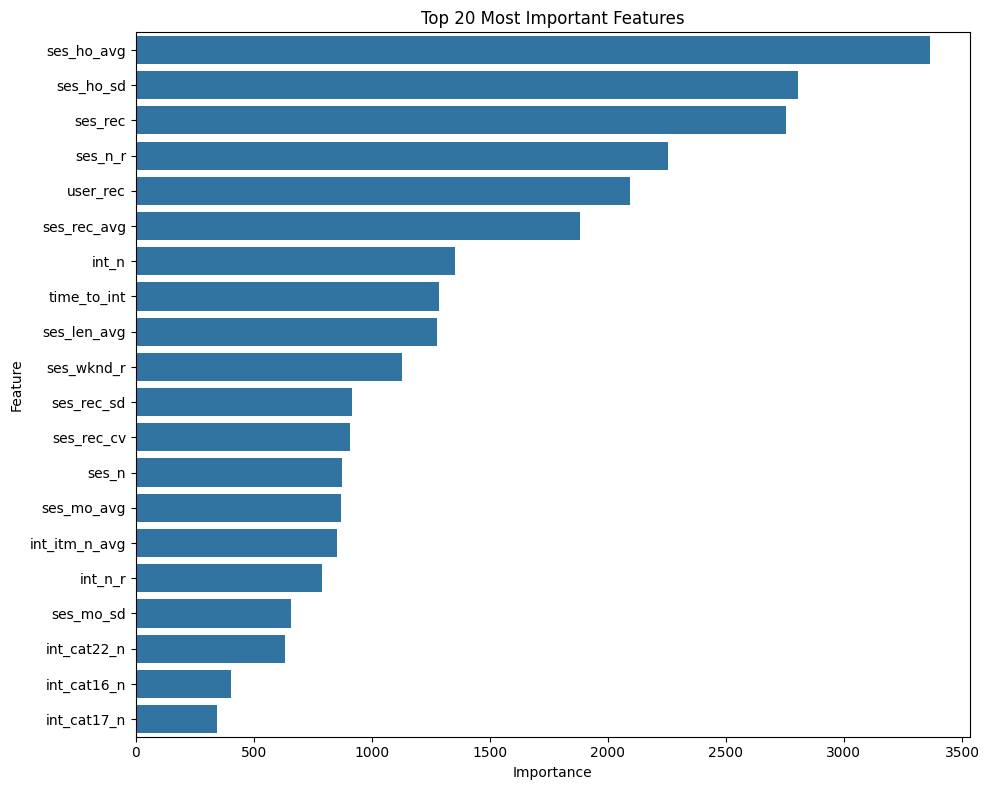

In [ ]:
# Візуалізуємо 20 найважливіших ознак для моделі LightGBM
# Використовуємо горизонтальний barplot для кращої читабельності

plt.figure(figsize=(10, 8))
sns.barplot(
    data=feat_importance_df.head(20),
    x='Importance',
    y='Feature'
)
plt.title("Top 20 Most Important Features")
plt.tight_layout()
plt.show()

**Аналіз важливості ознак**
На основі побудованого графіка видно, що модель LightGBM найбільше покладається на наступні ознаки:

**Найважливіші ознаки:**
* ses_ho_avg — середнє значення години, коли користувачі починали сесії -> ймовірно, відток залежить від часу доби, коли користувачі зазвичай активні.
* ses_ho_sd — стандартне відхилення години входу в систему -> користувачі з рутинною поведінкою можуть мати нижчу ймовірність відтоку.
* ses_rec — давність останньої сесії -> ключовий індикатор: чим давніше останній контакт, тим вищий ризик відтоку.
* ses_n_r — частота сесій по відношенню до зрілості -> активні користувачі в перерахунку на час є менш схильними до відтоку.
* user_rec — кількість днів з моменту першої сесії -> лояльні/довготривалі клієнти рідше припиняють користування.

**Інші фічі:**
* int_n, int_catX_n — взаємодії з платформою та категоріями товарів
* ses_len_avg, time_to_int — тривалість сесії та час до першої дії
* ses_wknd_r — частка вихідних: можливо, пов'язано зі звичками

**Висновок:**
Модель орієнтується переважно на **поведінкові метрики**, пов’язані з:
* часовими патернами (ses_ho_avg, ses_rec, ses_n_r)
* інтенсивністю активності
* стабільністю поведінки

Це узгоджується з бізнес-логікою: зміна активності або її відсутність — один з найпотужніших індикаторів потенційного відтоку.

In [ ]:
# Створюємо пояснювач на основі фінальної моделі (деревової структури)
explainer = shap.TreeExplainer(final_model)

# Обчислюємо SHAP-значення для кожного прикладу в навчальному наборі
# Для задачі бінарної класифікації повертається список із двох матриць:
# - shap_values[0]: вплив фіч на клас 0
# - shap_values[1]: вплив фіч на клас 1 (відтік)

shap_values = explainer.shap_values(X_scaled)

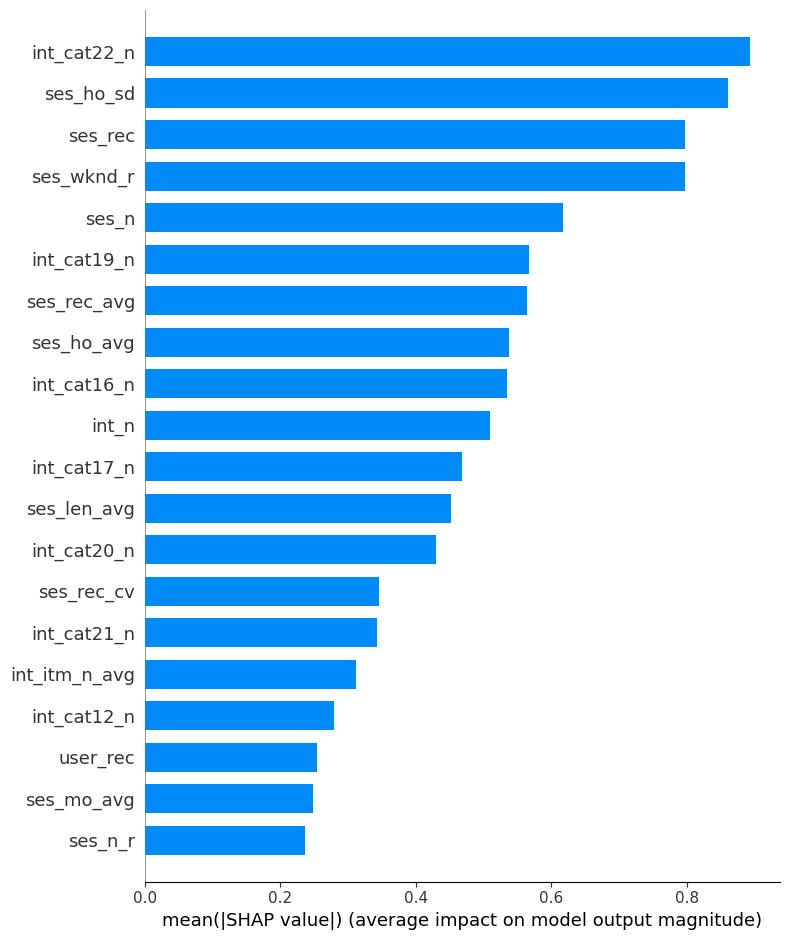

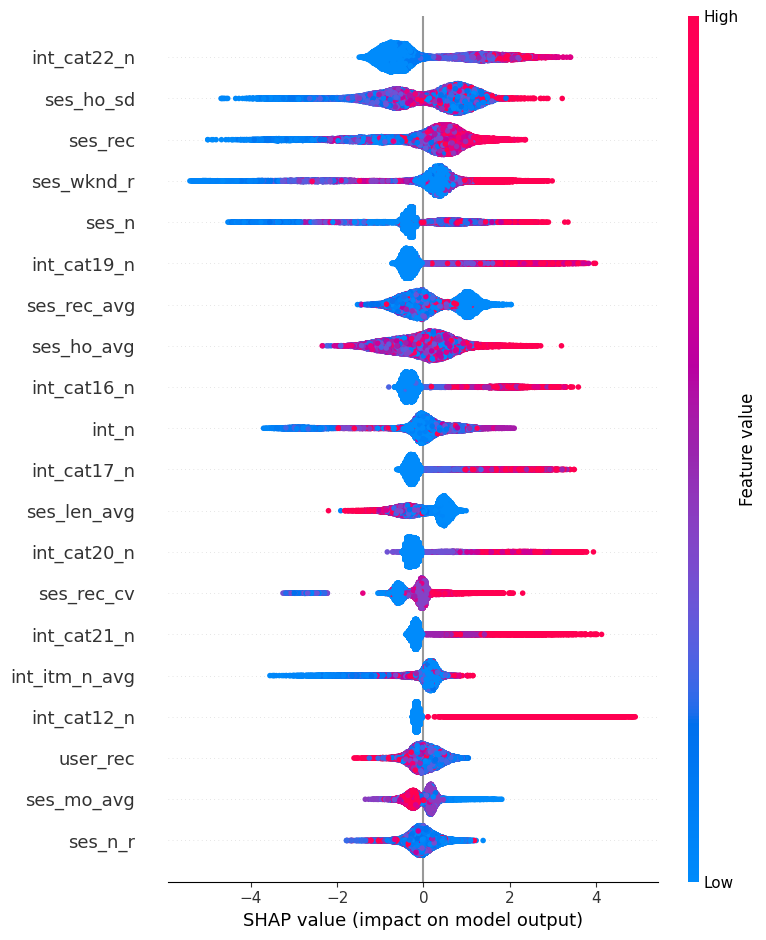

In [ ]:
# 1. Bar plot: усереднене абсолютне значення SHAP по кожній ознаці
# Показує загальну важливість фіч для прийняття рішень (як feature_importance)

shap.summary_plot(shap_values, X, plot_type="bar")

# 2. Summary dot plot: розгорнутий вплив кожної ознаки
# Кожна точка — це один приклад; колір = значення ознаки, вісь X = внесок у прогноз
# Чудово показує не лише важливість, але й напрям і розкид впливу

shap.summary_plot(shap_values, X)

**SHAP-аналіз: пояснення рішень моделі**

SHAP-значення дозволяють оцінити не лише важливість ознак, а й напрям і характер їх впливу на передбачення ймовірності відтоку клієнтів.

1. **Summary bar plot (усереднена важливість ознак)**

**Найбільший вплив на рішення моделі мають:**

* int_cat22_n — активність у певній категорії товарів
* ses_ho_sd та ses_ho_avg — стабільність та середній час активності користувача
* ses_rec, ses_wknd_r, ses_n — пов’язані з частотою та давністю сесій
* user_rec, ses_rec_avg — зрілість користувача та стабільність його активності

Ці ознаки вже раніше виявлялись важливими у LightGBM feature_importance — SHAP підтверджує їхню роль.

2. **Summary dot plot (SHAP values + розподіл значень)**

Цей графік демонструє:
* напрям впливу: наприклад, для ses_rec (давність останньої сесії):
  - високі значення (червоний) → додають до прогнозу відтоку
  - низькі значення (синій) → зменшують імовірність відтоку
* Для int_cat22_n: більше взаємодій → вищий ризик (можливо, спорадична взаємодія з цією категорією — ознака незадоволеності?)
* ses_ho_sd: високі коливання у часі активності теж пов’язані з підвищеною імовірністю відтоку — можливо, це свідчить про нестабільну звичку користування.

**Загальні висновки:**

* Модель орієнтується на поведінкові патерни, зокрема:
  - частоту й регулярність взаємодій
  - стабільність часу користування
  - активність у специфічних категоріях

* SHAP-графіки не лише підтверджують важливість ознак, але й допомагають зрозуміти, які конкретні значення приводять до класифікації як “ризик відтоку”.